<a href="https://colab.research.google.com/github/leonyangucl/2023fyp/blob/main/PD_inpainting5_formal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data pre-processing part

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import random
import nibabel as nib
from tqdm import tqdm
import os


from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras import backend as K
from keras.layers import Lambda

from skimage import img_as_float
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

##Read the data

In [ ]:

#pCASL
img_pCASL = nib.load('/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED/21174/ASL/pCASL_data.nii.gz')
#PD_cal
img_PD_cal = nib.load('/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED/21174/ASL/PD_cal.nii.gz')
#PWI_corr
img_PWI_corr = nib.load('/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED/21174/ASL/PWI_corr.nii.gz')
#ROI_hd
img_ROI_hd = nib.load('/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED/21174/T1/ROI_hd.nii.gz')
#T1_brain_hd
img_T1_brain_hd = nib.load('/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED/21174/T1/T1_brain_hd.nii.gz')
#ROI_regi
img_ROI_regi = nib.load('/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED/21174/T1/ROI_regi.nii.gz')
#T1_regi
img_T1_regi = nib.load('/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED/21174/T1/T1_regi.nii.gz')



Data shape example:

In [ ]:
data_pCASL = img_pCASL.get_fdata()
data_PD_cal = img_PD_cal.get_fdata()
data_PWI_corr = img_PWI_corr.get_fdata()
data_ROI_hd = img_ROI_hd.get_fdata()
data_T1_brain_hd = img_T1_brain_hd.get_fdata()
data_ROI_regi = img_ROI_regi.get_fdata()
data_T1_regi = img_T1_regi.get_fdata()


print(data_pCASL.shape)
print(data_PD_cal.shape)
print(data_PWI_corr.shape)
print(data_ROI_hd.shape)
print(data_T1_brain_hd.shape)
print(data_ROI_regi.shape)
print(data_T1_regi.shape)

(80, 80, 20, 70)
(80, 80, 20, 3)
(80, 80, 20)
(192, 256, 192)
(192, 256, 192)
(80, 80, 20)
(80, 80, 20)


In [ ]:
dir_path = '/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED'

all_folder_names = os.listdir(dir_path)

# Split the folders into train and test sets
train_folders, test_folders = train_test_split(all_folder_names, test_size=0.2)

def process_folders(folder_list):
    all_data = []
    all_masks = []  # Add a list to store masks
    for folder_name in folder_list:
        file_path = os.path.join(dir_path, folder_name, 'ASL', 'PD_cal.nii.gz')
        mask_path = os.path.join(dir_path, folder_name, 'T1', 'ROI_regi.nii.gz')  # Define the mask path
        if os.path.exists(file_path) and os.path.exists(mask_path):  # Check if both data and mask exist
            img = nib.load(file_path)
            mask = nib.load(mask_path)
            data = img.get_fdata()
            mask_data = mask.get_fdata()
            # Calculate the mean of PD images
            mean_data = np.mean(data, axis=3)

            mean_data_1 = mean_data[..., 8:18]
            mask_data_1 = mask_data[..., 8:18]

            #volume-wise normalisation
            lower, upper = np.percentile(mean_data_1, [1, 99])
            norm_data = np.clip(mean_data_1, lower, upper)
            norm_data = (norm_data - lower) / (upper - lower)


            for j in range(10):
                slice_data = norm_data[..., j]
                slice_mask = mask_data_1[..., j]
                slice_mask = np.where(slice_mask == 0, 1, 0) #change the value of the mask
                # normalization for each slice
                # min_val = np.min(slice_data)
                # max_val = np.max(slice_data)
                # norm_data = (slice_data - min_val) / (max_val - min_val) if max_val > min_val else slice_data
                all_data.append(slice_data)
                all_masks.append(slice_mask)  # Add the slice of the mask to the list

    dataset = np.stack(all_data)
    maskset = np.stack(all_masks)
    return dataset, maskset


train_dataset, train_masks = process_folders(train_folders)
test_dataset, test_masks = process_folders(test_folders)

print('train data:', train_dataset.shape)
print('train masks:', train_masks.shape)
print('test data:', test_dataset.shape)
print('test masks:', test_masks.shape)

train data: (450, 80, 80)
train masks: (450, 80, 80)
test data: (120, 80, 80)
test masks: (120, 80, 80)


In [ ]:
# Check the number of all-zero masks in train_masks
zero_mask_count = np.sum(np.all(train_masks == 0, axis=(1,2)))
print('Number of all-zero masks in train_masks:', zero_mask_count)


Number of all-zero masks in train_masks: 0


In [ ]:
# ## old method
# from sklearn.model_selection import train_test_split

# dir_path = '/content/drive/MyDrive/Colab Notebooks/thesis/ANONYMISED'

# all_folder_names = os.listdir(dir_path)

# # Split the folders into train and test sets
# train_folders, test_folders = train_test_split(all_folder_names, test_size=0.2)

# def process_folders(folder_list):
#     all_data = []
#     all_masks = []  # Add a list to store masks
#     for folder_name in folder_list:
#         file_path = os.path.join(dir_path, folder_name, 'ASL', 'PD_cal.nii.gz')
#         mask_path = os.path.join(dir_path, folder_name, 'T1', 'ROI_regi.nii.gz')  # Define the mask path
#         if os.path.exists(file_path) and os.path.exists(mask_path):  # Check if both data and mask exist
#             img = nib.load(file_path)
#             mask = nib.load(mask_path)  # Load the mask
#             data = img.get_fdata()
#             mask_data = mask.get_fdata()  # Get the mask data
#             # Calculate the mean along the last dimension
#             mean_data = np.mean(data, axis=3)
#             for j in range(8, 18):
#                 slice_data = mean_data[..., j]
#                 slice_mask = mask_data[..., j]  # Get the corresponding slice of the mask
#                 slice_mask = np.where(slice_mask == 0, 1, 0) #change the value of the mask    # test code
#                 # normalization for each slice
#                 min_val = np.min(slice_data)
#                 max_val = np.max(slice_data)
#                 norm_data = (slice_data - min_val) / (max_val - min_val) if max_val > min_val else slice_data
#                 all_data.append(norm_data)
#                 all_masks.append(slice_mask)  # Add the slice of the mask to the list

#     dataset = np.stack(all_data)
#     maskset = np.stack(all_masks)  # Stack the masks into an array
#     return dataset, maskset  # Return both data and masks

# # Process the train and test sets separately
# train_dataset, train_masks = process_folders(train_folders)  # Get both data and masks for training
# test_dataset, test_masks = process_folders(test_folders)  # Get both data and masks for testing

# print('train data:', train_dataset.shape)
# print('train masks:', train_masks.shape)
# print('test data:', test_dataset.shape)
# print('test masks:', test_masks.shape)

Augmentation (for both data and corresponding masks)

In [ ]:
def augment_data(dataset, dataset_labels, aug_times, method):
    aug_dataset = []
    aug_dataset_labels = []


    augment = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    if method == 'data':
        for num in range(len(dataset)):
            aug_data = dataset[num]
            aug_data = aug_data.reshape((1,) + aug_data.shape + (1,))
            aug_label = dataset_labels[num]
            aug_label = aug_label.reshape((1,) + aug_label.shape + (1,))
            i = 0
            for batch_data, batch_label in augment.flow(aug_data, aug_label, batch_size=1):
                aug_dataset.append(batch_data[0,:,:,0])
                aug_dataset_labels.append(batch_label[0,:,:,0])
                i += 1
                if i > aug_times:
                    break

    if method == 'mask':
        for num in range(len(dataset)):
            aug_data = dataset[num]
            aug_data = aug_data.reshape((1,) + aug_data.shape + (1,))
            aug_label = dataset_labels[num]
            aug_label = aug_label.reshape((1,) + aug_label.shape + (1,))
            i = 0
            for batch_data, batch_label in augment.flow(aug_data, aug_label, batch_size=1):
                aug_dataset.append(np.round(batch_data[0,:,:,0]))
                aug_dataset_labels.append(np.round(batch_label[0,:,:,0]))
                i += 1
                if i > aug_times:
                    break


    return np.array(aug_dataset), np.array(aug_dataset_labels)



In [ ]:
aug_train_dataset, aug_train_masks = augment_data(train_dataset, train_masks,9,'data')

print(aug_train_dataset.shape)
unique_values = np.unique(aug_train_masks)
print('Unique values in the masks:', unique_values)

(4500, 80, 80)
Unique values in the masks: [0 1]


### Useless code

In [ ]:
def calculate_area_statistics(maskset):
    # Calculate the area of each mask (the number of zeros in each mask)
    mask_areas = [np.sum(mask == 0) for mask in maskset]

    # Calculate minimum, maximum and average of the areas
    min_area = np.min(mask_areas)
    max_area = np.max(mask_areas)
    avg_area = np.mean(mask_areas)

    return min_area, max_area, avg_area

# Calculate the area statistics for both training masks and testing masks
train_min_area, train_max_area, train_avg_area = calculate_area_statistics(train_masks)
test_min_area, test_max_area, test_avg_area = calculate_area_statistics(test_masks)

print('Training masks - Min area: {}, Max area: {}, Avg area: {}'.format(train_min_area, train_max_area, train_avg_area))
print('Testing masks - Min area: {}, Max area: {}, Avg area: {}'.format(test_min_area, test_max_area, test_avg_area))


Training masks - Min area: 0, Max area: 538, Avg area: 108.48
Testing masks - Min area: 0, Max area: 465, Avg area: 112.03333333333333


In [ ]:
def calculate_area_statistics_and_max_index(maskset):
    # Calculate the area of each mask (the number of zeros in each mask)
    mask_areas = [np.sum(mask == 0) for mask in maskset]

    # Calculate minimum, maximum and average of the areas
    min_area = np.min(mask_areas)
    max_area = np.max(mask_areas)
    avg_area = np.mean(mask_areas)

    # Get the index of the mask with maximum area
    max_area_index = np.argmax(mask_areas)

    return min_area, max_area, avg_area, max_area_index

# Calculate the area statistics and maximum area index for both training masks and testing masks
train_min_area, train_max_area, train_avg_area, train_max_area_index = calculate_area_statistics_and_max_index(train_masks)
test_min_area, test_max_area, test_avg_area, test_max_area_index = calculate_area_statistics_and_max_index(test_masks)

print('Training masks - Min area: {}, Max area: {}, Avg area: {}, Max area index: {}'.format(train_min_area, train_max_area, train_avg_area, train_max_area_index))
print('Testing masks - Min area: {}, Max area: {}, Avg area: {}, Max area index: {}'.format(test_min_area, test_max_area, test_avg_area, test_max_area_index))


Training masks - Min area: 0, Max area: 538, Avg area: 108.48, Max area index: 164
Testing masks - Min area: 0, Max area: 465, Avg area: 112.03333333333333, Max area index: 1


In [ ]:
def calculate_bounding_box(mask):
    # Get the x and y coordinates of the mask region
    x, y = np.where(mask == 0)

    # Calculate the minimum and maximum coordinates in both directions
    min_x, max_x = np.min(x), np.max(x)
    min_y, max_y = np.min(y), np.max(y)

    return min_x, max_x, min_y, max_y

# Calculate the bounding box for the mask with maximum area in the training set
min_x, max_x, min_y, max_y = calculate_bounding_box(train_masks[train_max_area_index])

# Calculate the length and width of the bounding box
bounding_box_length = max_x - min_x + 1
bounding_box_width = max_y - min_y + 1
print('Bounding box length: {}, Bounding box width: {}'.format(bounding_box_length, bounding_box_width))


Bounding box length: 23, Bounding box width: 36


In [ ]:
def count_large_bounding_box(masks):
    count = 0
    for mask in masks:
        # Find the indices where mask is 0
        indices = np.where(mask == 0)
        #print(indices) ##debug line

        # If there are no zeros in the mask, continue to the next mask
        if len(indices[0]) == 0 or len(indices[1]) == 0:
            continue

        # Calculate bounding box dimensions
        min_x, max_x = np.min(indices[0]), np.max(indices[0])
        min_y, max_y = np.min(indices[1]), np.max(indices[1])

        # If the width or the height of the bounding box is greater than 32, increment the count
        if max_x - min_x + 1 > 32 or max_y - min_y + 1 > 32:
            count += 1

    return count

# Calculate the number of masks with a large bounding box in the training set
train_large_bb_count = count_large_bounding_box(train_masks)
print('Number of large bounding boxes in training set: ', train_large_bb_count)

# Calculate the number of masks with a large bounding box in the testing set
test_large_bb_count = count_large_bounding_box(test_masks)
print('Number of large bounding boxes in testing set: ', test_large_bb_count)


Number of large bounding boxes in training set:  29
Number of large bounding boxes in testing set:  6


In [ ]:
max_val=np.max(train_dataset[15,:,:])
max_val

1.0

### example

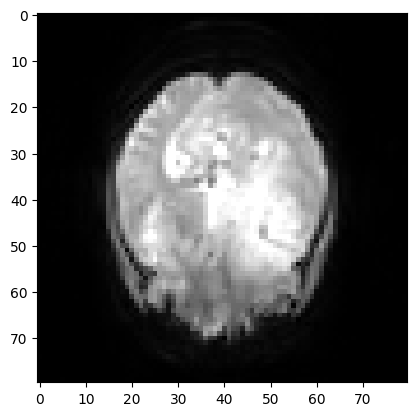

In [ ]:
plt.imshow(train_dataset[50,:,:].T,cmap='gray')
plt.show()

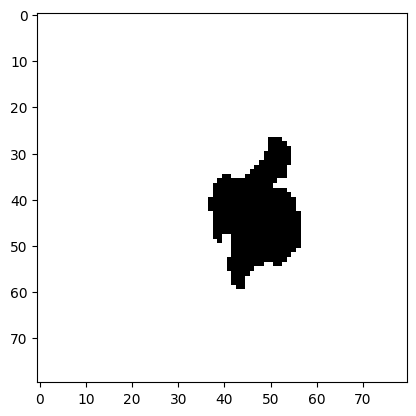

In [ ]:
plt.imshow(train_masks[50,:,:].T,cmap='gray')
plt.show()

##Image cropping

In [ ]:
def random_crop(data, masks, crop_size=(32, 32), min_nonzero_ratio=4/5, crops_per_image=8, threshold=1e-02, max_attempts=100):
    cropped_data = []
    for i in tqdm(range(len(data)), desc='Cropping images'):
        img = data[i]
        mask = masks[i]
        crop_counter = 0
        attempt_counter = 0
        while crop_counter < crops_per_image and attempt_counter < max_attempts:
            # We randomly choose the starting point of cropping
            start_x = np.random.randint(0, img.shape[1] - crop_size[0] + 1)
            start_y = np.random.randint(0, img.shape[0] - crop_size[1] + 1)

            # Crop the image and the corresponding mask
            cropped = img[start_y:start_y + crop_size[1], start_x:start_x + crop_size[0]]
            cropped_mask = mask[start_y:start_y + crop_size[1], start_x:start_x + crop_size[0]]

            # Check whether all pixels in the cropped mask are 1 and the ratio of valid information is enough
            if np.all(cropped_mask == 1) and np.count_nonzero(cropped > threshold) / (crop_size[0] * crop_size[1]) >= min_nonzero_ratio:
                cropped_data.append(cropped)
                crop_counter += 1

            attempt_counter += 1

    return np.array(cropped_data)

# cropped_train_data = random_crop(train_dataset, train_masks)
# cropped_test_data = random_crop(test_dataset, test_masks)

# print('\ntrain data:', cropped_train_data.shape)
# print('test data:', cropped_test_data.shape)


In [ ]:
cropped_train_data = random_crop(aug_train_dataset, aug_train_masks)
cropped_test_data = random_crop(test_dataset, test_masks)

print('\ntrain data:', cropped_train_data.shape)
print('test data:', cropped_test_data.shape)


Cropping images: 100%|██████████| 120/120 [00:00<00:00, 898.77it/s]


train data: (26833, 32, 32)
test data: (727, 32, 32)


Some examples of the cropped data

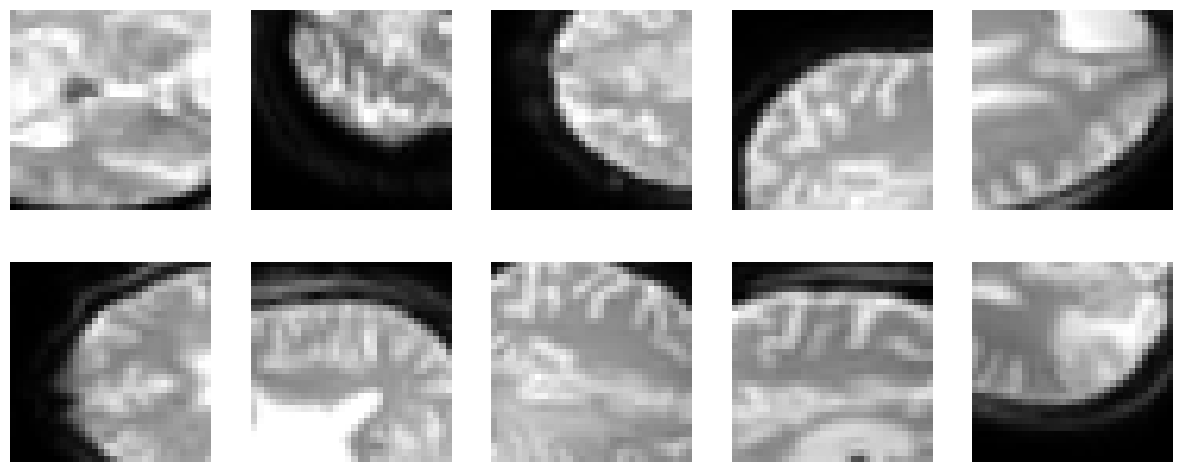

In [ ]:
import matplotlib.pyplot as plt


indices = np.random.choice(len(cropped_train_data), size=10, replace=False)


fig, axes = plt.subplots(2, 5, figsize=(15, 6))


for ax, idx in zip(axes.flatten(), indices):
    ax.imshow(cropped_train_data[idx], cmap='gray')
    ax.axis('off')
plt.show()


## Mask generating

In [ ]:
def crop_images(data, masks, crop_size=(32, 32)):
    X_real, masks_real, X_real_whole = [], [], []
    half_size = crop_size[0] // 2, crop_size[1] // 2  # half size of the crop size

    for i in range(len(data)):
        img = data[i]
        mask = masks[i]

        # Check if the mask is all ones
        if np.all(mask == 1):
            continue

        # Find the coordinates of the region where mask equals to 0
        coords = np.where(mask == 0)
        min_y, max_y = np.min(coords[0]), np.max(coords[0])
        min_x, max_x = np.min(coords[1]), np.max(coords[1])

        # Check if the region is too large
        if max_y - min_y >= crop_size[0] or max_x - min_x >= crop_size[1]:
            continue

        # Otherwise, calculate the center of the region
        center_y, center_x = (min_y + max_y) // 2, (min_x + max_x) // 2

        # Calculate the top-left and bottom-right coordinates of the crop area
        start_y, end_y = max(0, center_y - half_size[0]), min(img.shape[0], center_y + half_size[0])
        start_x, end_x = max(0, center_x - half_size[1]), min(img.shape[1], center_x + half_size[1])

        # Crop the region from the image and mask
        cropped = img[start_y:end_y, start_x:end_x]
        cropped_mask = mask[start_y:end_y, start_x:end_x]

        # If the cropped region is smaller than the desired size, pad it with zeros
        if cropped.shape[0] < crop_size[0] or cropped.shape[1] < crop_size[1]:
            padded = np.zeros(crop_size)
            padded[:cropped.shape[0], :cropped.shape[1]] = cropped
            cropped = padded

            padded_mask = np.ones(crop_size)
            padded_mask[:cropped_mask.shape[0], :cropped_mask.shape[1]] = cropped_mask
            cropped_mask = padded_mask

        X_real.append(cropped)
        masks_real.append(cropped_mask)
        X_real_whole.append(img)

    return np.array(X_real), np.array(masks_real), np.array(X_real_whole)

X_real_train, masks_real_train, X_real_whole_train = crop_images(train_dataset, train_masks)
X_real_test, masks_real_test, X_real_whole_test = crop_images(test_dataset, test_masks)


X_masked_test = X_real_test * masks_real_test


print('train data:', X_real_train.shape)
print('train masks:', masks_real_train.shape)
print('train whole data:', X_real_whole_train.shape)
print('test data:', X_real_test.shape)
print('test masks:', masks_real_test.shape)
print('test whole data:', X_real_whole_test.shape)
print('test data masked:', X_masked_test.shape)


train data: (291, 32, 32)
train masks: (291, 32, 32)
train whole data: (291, 80, 80)
test data: (75, 32, 32)
test masks: (75, 32, 32)
test whole data: (75, 80, 80)
test data masked: (75, 32, 32)


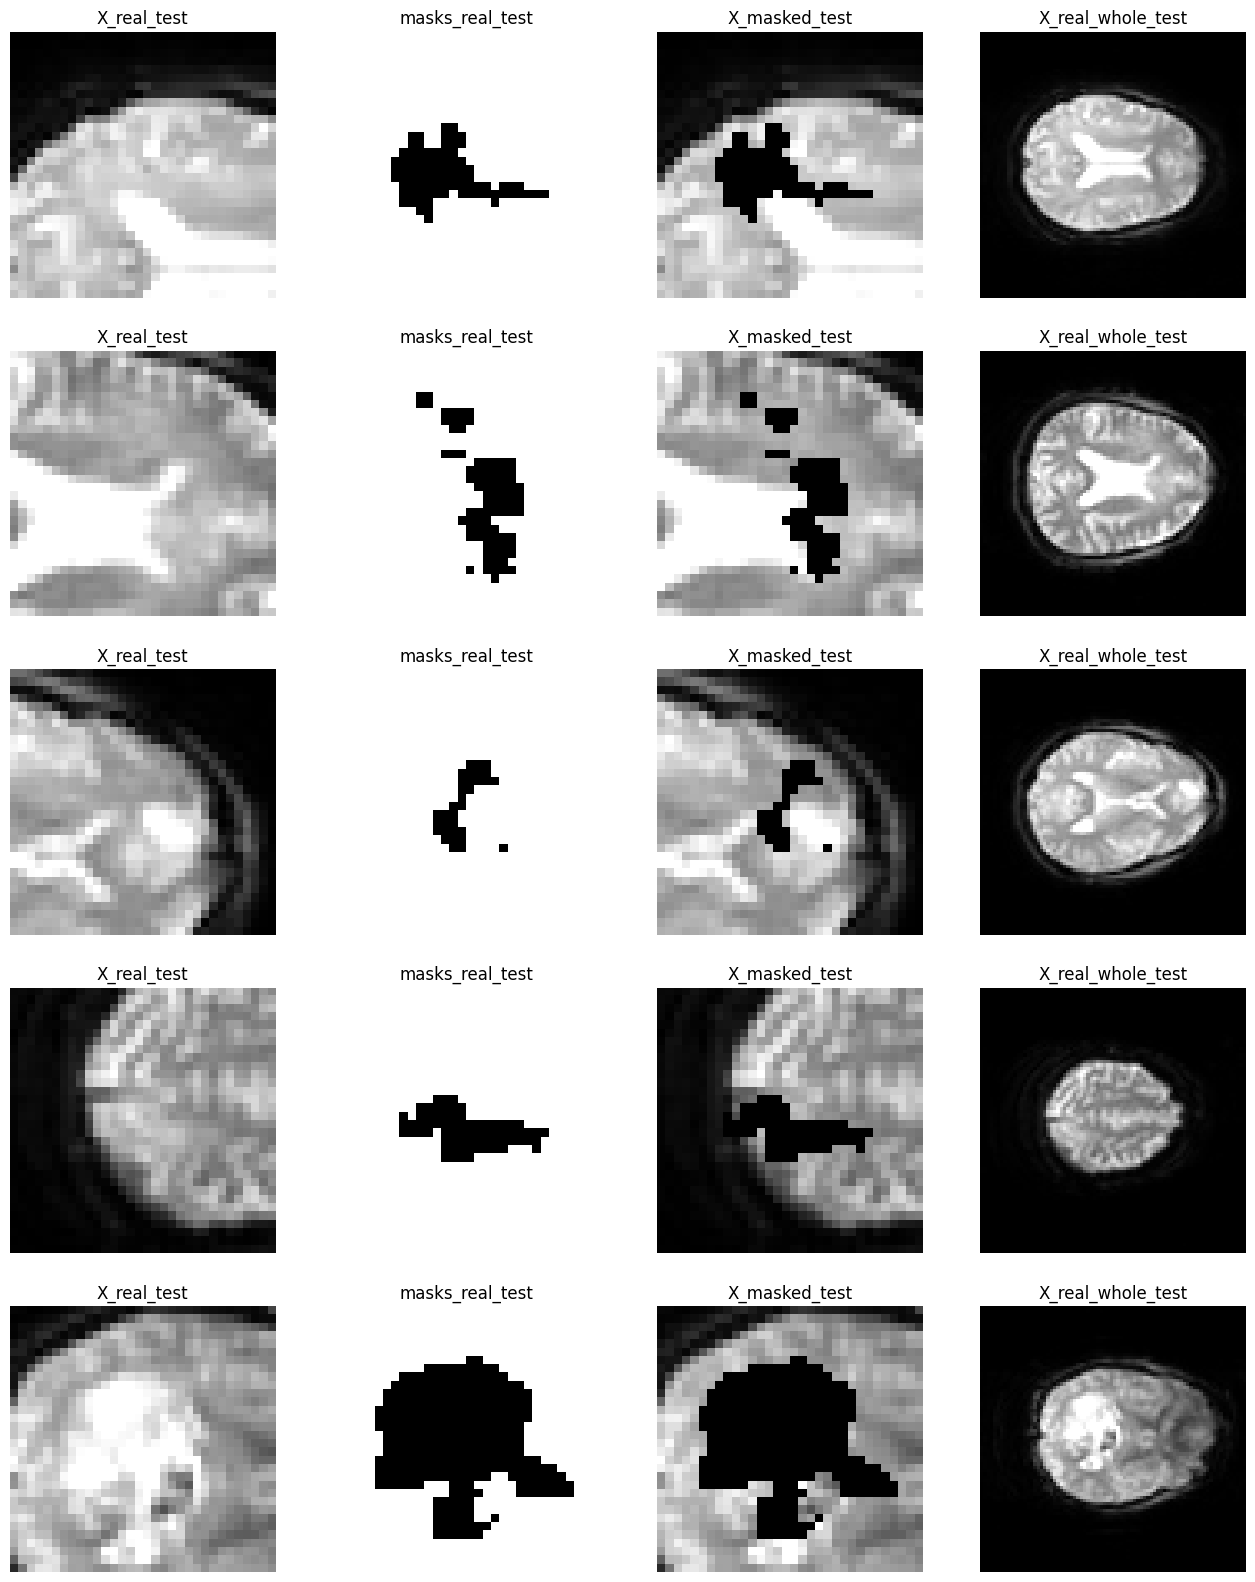

In [ ]:
import matplotlib.pyplot as plt
import random


def display_images(X_real, masks_real, X_masked, X_real_whole):
    fig, axs = plt.subplots(5, 4, figsize=(16, 20))

    for i, idx in enumerate(random.sample(range(X_real.shape[0]), 5)):
        axs[i, 0].imshow(X_real[idx], cmap='gray')
        axs[i, 0].set_title('X_real_test')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(masks_real[idx], cmap='gray')
        axs[i, 1].set_title('masks_real_test')
        axs[i, 1].axis('off')

        axs[i, 2].imshow(X_masked[idx], cmap='gray')
        axs[i, 2].set_title('X_masked_test')
        axs[i, 2].axis('off')

        axs[i, 3].imshow(X_real_whole[idx], cmap='gray')
        axs[i, 3].set_title('X_real_whole_test')
        axs[i, 3].axis('off')

    plt.show()


display_images(X_real_test, masks_real_test, X_masked_test, X_real_whole_test)


In [ ]:
aug_masks_real_train, _ = augment_data(masks_real_train, masks_real_train,150, 'mask')
aug_masks_real_train_1, _ = augment_data(masks_real_train, masks_real_train,10, 'mask')

np.random.shuffle(aug_masks_real_train)
np.random.shuffle(aug_masks_real_train_1)

aug_masks_real_train = aug_masks_real_train[:cropped_train_data.shape[0]]
aug_masks_real_train_1 = aug_masks_real_train[:cropped_test_data.shape[0]]
print(aug_masks_real_train.shape)
print(aug_masks_real_train_1.shape)




(26833, 32, 32)
(727, 32, 32)


We can see the shapes of data & masks are the same

In [ ]:
print('train data shape:', cropped_train_data.shape)
print('test data shape:', cropped_test_data.shape)
print('masks_train shape:', aug_masks_real_train.shape)
print('masks_test shape:',aug_masks_real_train_1.shape)

train data shape: (26833, 32, 32)
test data shape: (727, 32, 32)
masks_train shape: (26833, 32, 32)
masks_test shape: (727, 32, 32)


Some examples of masks

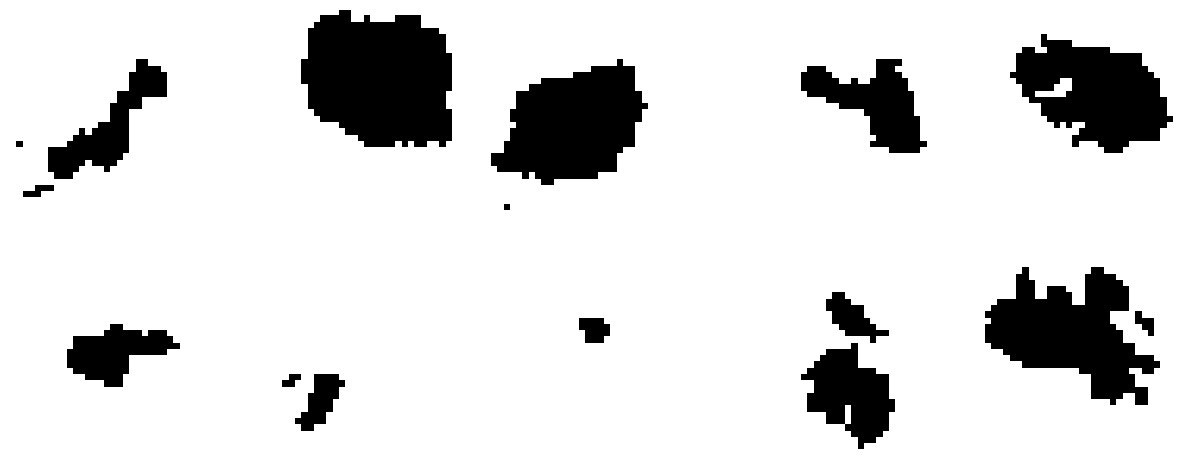

In [ ]:
import matplotlib.pyplot as plt


indices = np.random.choice(len(aug_masks_real_train), size=10, replace=False)


fig, axes = plt.subplots(2, 5, figsize=(15, 6))


for ax, idx in zip(axes.flatten(), indices):
    ax.imshow(aug_masks_real_train[idx], cmap='gray')
    ax.axis('off')
plt.show()


Make sure the masks only have 0 and 1.

In [ ]:
np.unique(aug_masks_real_train)

array([0., 1.], dtype=float32)

## Train & Test Data

In [ ]:
X_train = cropped_train_data * aug_masks_real_train
X_test = cropped_test_data * aug_masks_real_train_1

masks_train = aug_masks_real_train
masks_test = aug_masks_real_train_1

y_train = cropped_train_data
y_test = cropped_test_data

print(X_train.shape)
print(X_test.shape)
print(masks_train.shape)
print(masks_test.shape)
print(y_train.shape)
print(y_test.shape)

(26833, 32, 32)
(727, 32, 32)
(26833, 32, 32)
(727, 32, 32)
(26833, 32, 32)
(727, 32, 32)


examples of X_train, masks_train, y_train

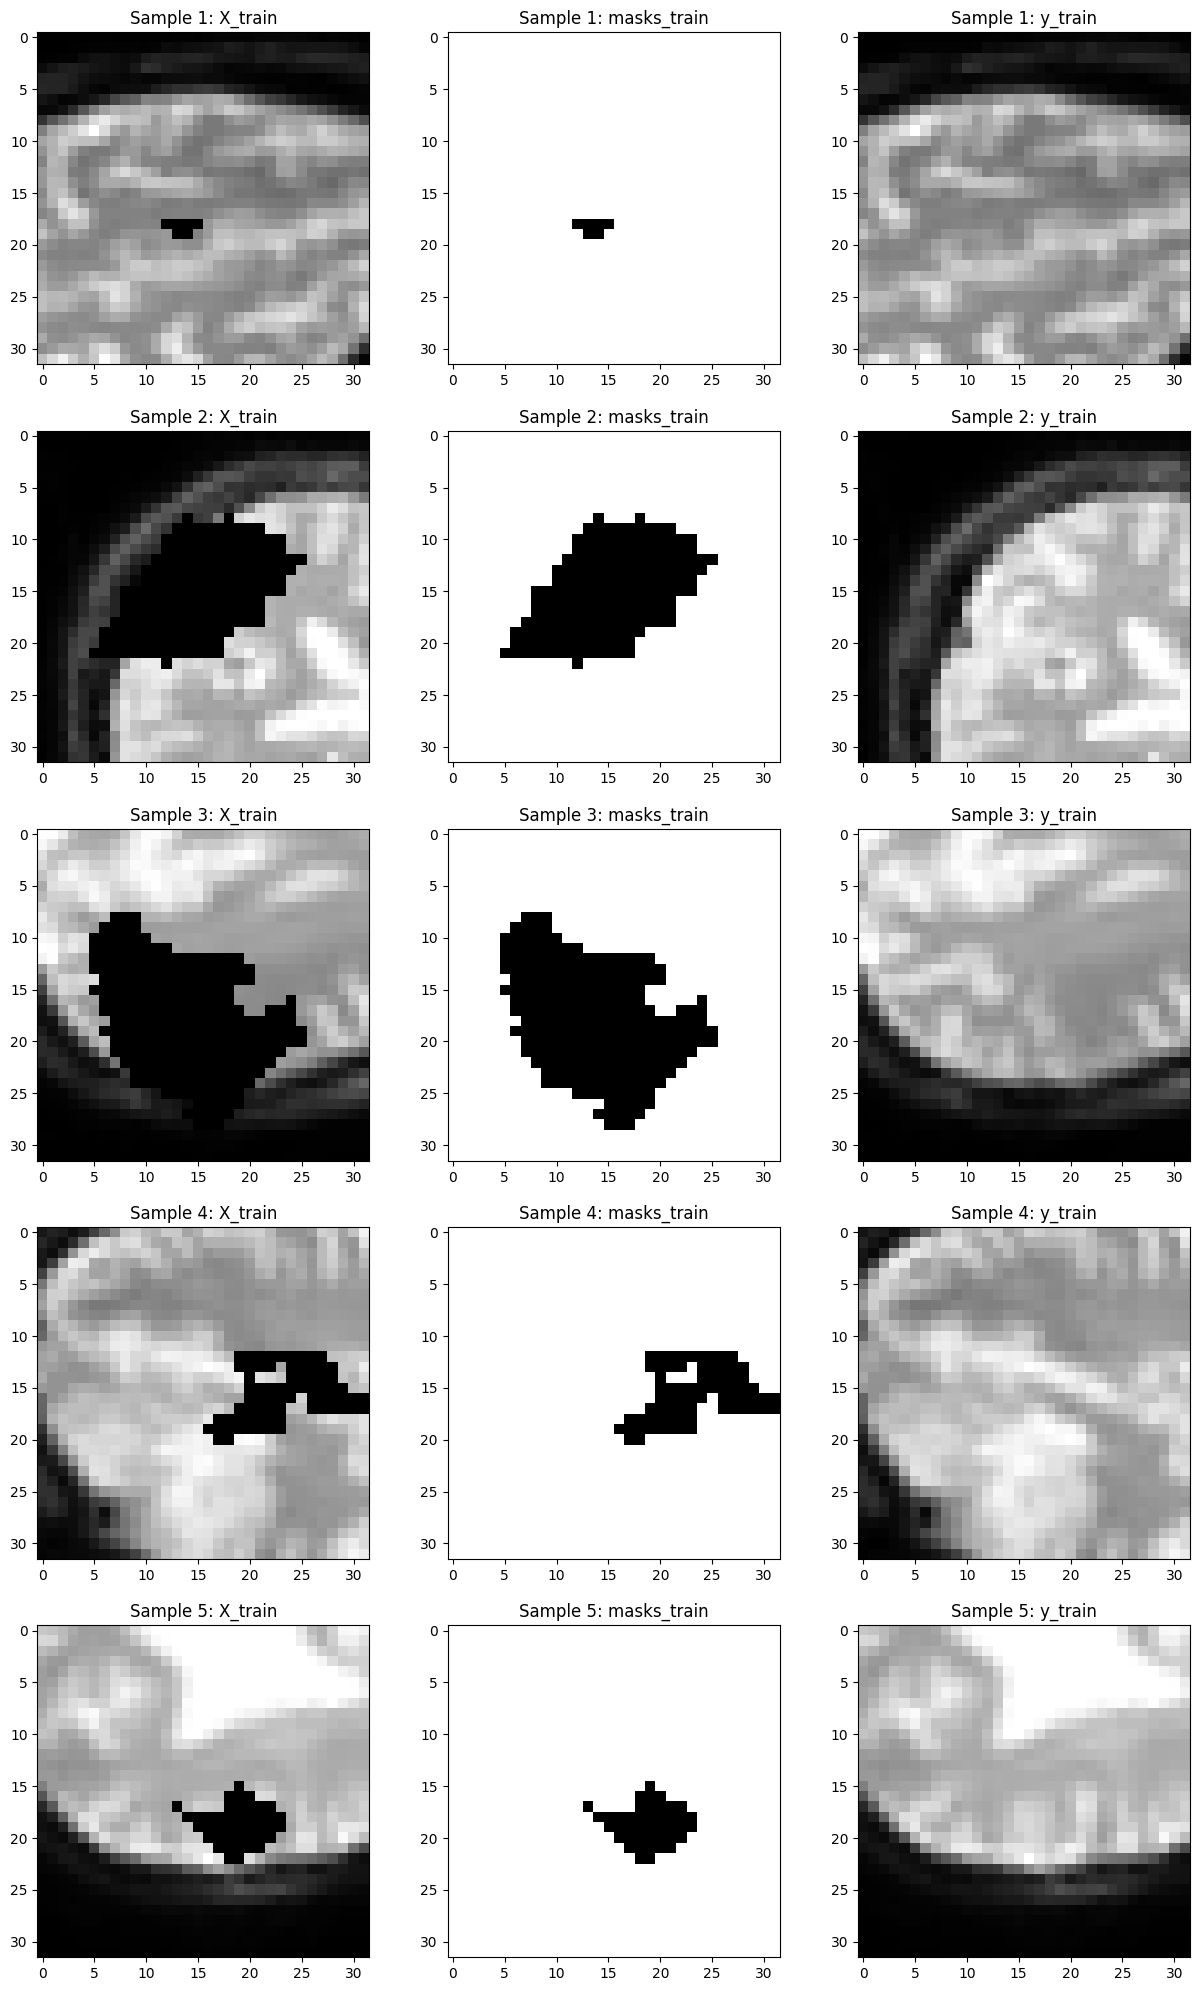

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


num_samples = X_train.shape[0]

fig, axs = plt.subplots(5, 3, figsize=(15, 25))

for i in range(5):
    idx = np.random.randint(num_samples)


    axs[i, 0].imshow(X_train[idx], cmap='gray')
    axs[i, 0].set_title(f'Sample {i+1}: X_train')


    axs[i, 1].imshow(masks_train[idx], cmap='gray')
    axs[i, 1].set_title(f'Sample {i+1}: masks_train')


    axs[i, 2].imshow(y_train[idx], cmap='gray')
    axs[i, 2].set_title(f'Sample {i+1}: y_train')


plt.show()


## useless code

In [ ]:
# # Initialize a data generator
# from keras.preprocessing.image import ImageDataGenerator
# datagen = ImageDataGenerator(
#     rotation_range=10,  # Degree range for random rotations
#     width_shift_range=0.1,  # Range for random horizontal shifts
#     height_shift_range=0.1,  # Range for random vertical shifts
#     shear_range=0.1,  # Shear Intensity (Shear angle in counter-clockwise direction in degrees)
#     zoom_range=0.1,  # Range for random zoom
#     horizontal_flip=True,  # Randomly flip inputs horizontally
#     fill_mode='nearest'  # Points outside the boundaries of the input are filled according to the given mode
# )

# # Generate more masks for training data
# masks_real_augmented = []

# for i in range(len(masks_real_train)):
#     mask = masks_real_train[i]
#     # We'll generate 5 augmented masks for each original mask
#     for _ in range(5):
#         mask_tensor = np.expand_dims(mask, axis=0)
#         mask_augmented = datagen.flow(mask_tensor, batch_size=1)[0].astype('float32')
#         masks_real_augmented.append(mask_augmented)

# # Combine original and augmented masks
# masks_real_train = np.concatenate([masks_real_train, np.array(masks_real_augmented)], axis=0)

# # Then we need to create the new training and testing sets based on the length of your cropped_train_data and cropped_test_data
# masks_real_train = np.random.permutation(masks_real_train)[:len(cropped_train_data)]
# masks_real_test = np.random.permutation(masks_real_train)[:len(cropped_test_data)]

# print('train masks:', masks_real_train.shape)
# print('test masks:', masks_real_test.shape)


### Define some irregular mask (deprecate)

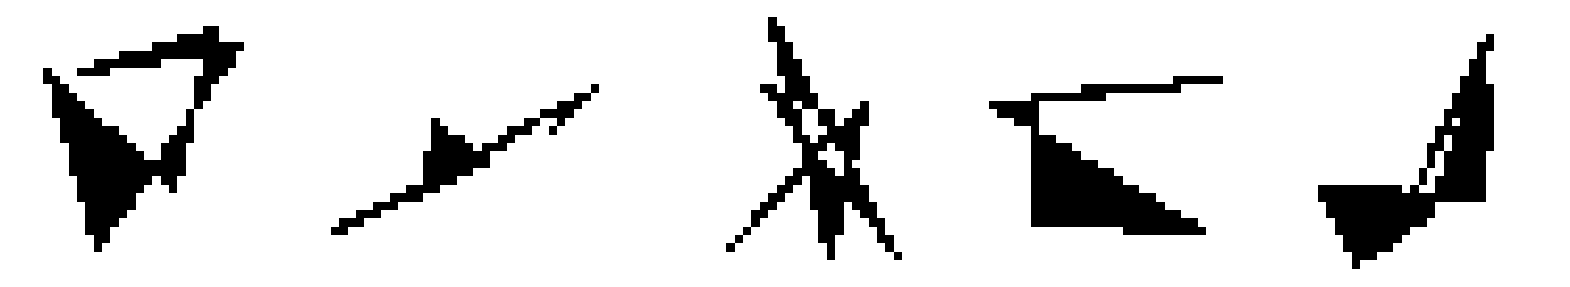

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


max_vertex = 10
min_vertex = 5
max_length = 50
max_brush_width = 10
img_shape = (32, 32)

def generate_irregular_mask(img_shape, min_vertex=3, max_vertex=10, max_length=10, max_brush_width=10):
    mask = np.ones(img_shape, np.uint8) *255  # Initialize the mask as all ones (255)

    # Number of vertexes of polygon
    num_vertexes = np.random.randint(min_vertex, max_vertex + 1)

    # Vertexes of the polygon
    vertexes = []
    for _ in range(num_vertexes):
        vertex = (abs(np.random.randint(img_shape[0])), abs(np.random.randint(img_shape[1])))
        vertexes.append(vertex)

    # Width of the brushes
    brush_width = np.random.randint(max_brush_width)

    # Draw polygon and fill with 0
    cv2.fillPoly(mask, [np.array(vertexes, dtype=np.int32)], 0)

    return mask

# Generate masks
masks = []
for _ in range(5):  # Generate 5 masks
    mask = generate_irregular_mask(img_shape, min_vertex, max_vertex, max_length, max_brush_width)
    masks.append(mask)

# Plot masks
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, mask in enumerate(masks):
    axs[i].imshow(mask, cmap='gray')
    axs[i].axis('off')
plt.show()


### Apply the masks (deprecate)

In [ ]:
def generate_multiple_masks_and_apply(dataset, num_masks=5):
    masked_datasets = []
    masks_storage = []

    for data in dataset:
        for _ in range(num_masks):
            irregular_mask = generate_irregular_mask(data.shape)
            masked_data = data * irregular_mask
            masked_datasets.append(masked_data)
            masks_storage.append(irregular_mask)

    return np.array(masked_datasets), np.array(masks_storage)

# Generate 5 masks for each image in the dataset
X_train, masks_train = generate_multiple_masks_and_apply(cropped_train_data)
X_test, masks_test = generate_multiple_masks_and_apply(cropped_test_data)

# Repeat the original data to match the number of masks
y_train = np.repeat(cropped_train_data, 5, axis=0)
y_test = np.repeat(cropped_test_data, 5, axis=0)


print(X_train.shape)
print(masks_train.shape)
print(y_train.shape)
print(X_test.shape)
print(masks_test.shape)
print(y_test.shape)



(13140, 32, 32)
(13140, 32, 32)
(13140, 32, 32)
(3285, 32, 32)
(3285, 32, 32)
(3285, 32, 32)


### some examples (deprecate)

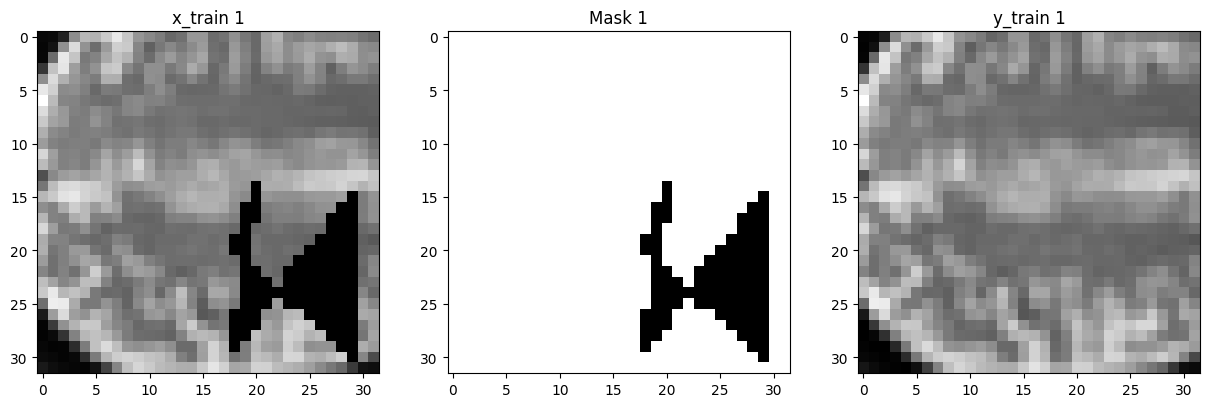

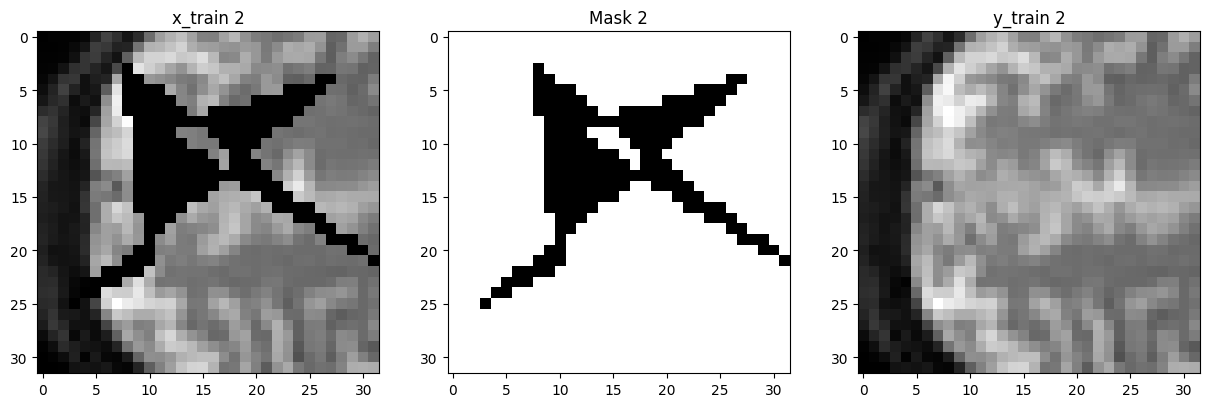

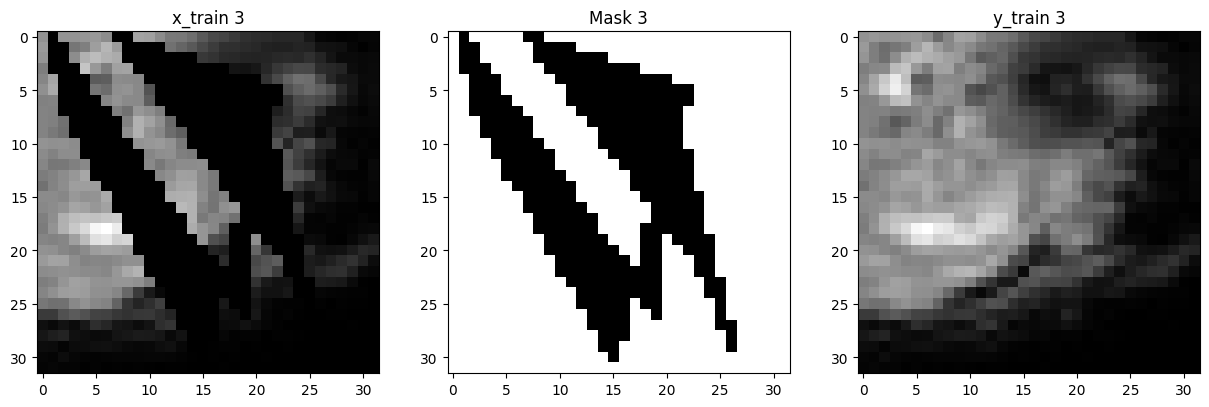

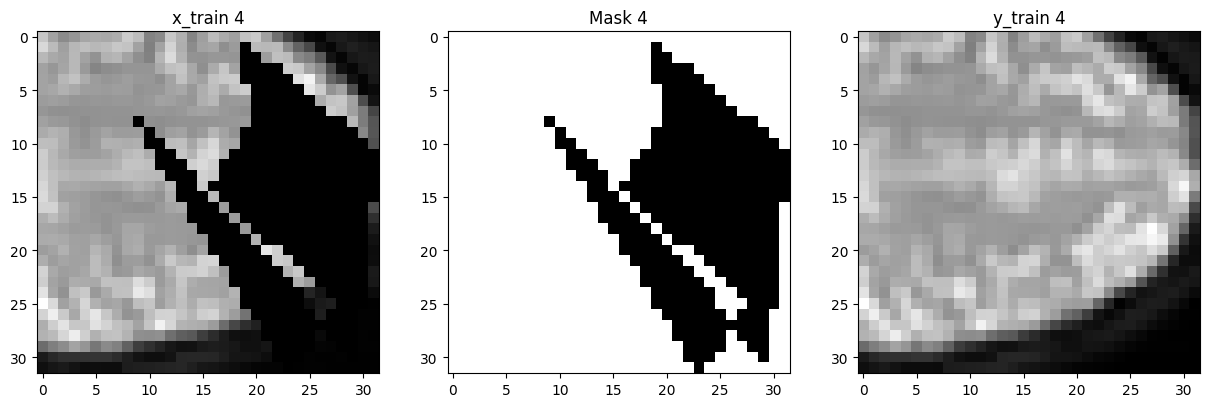

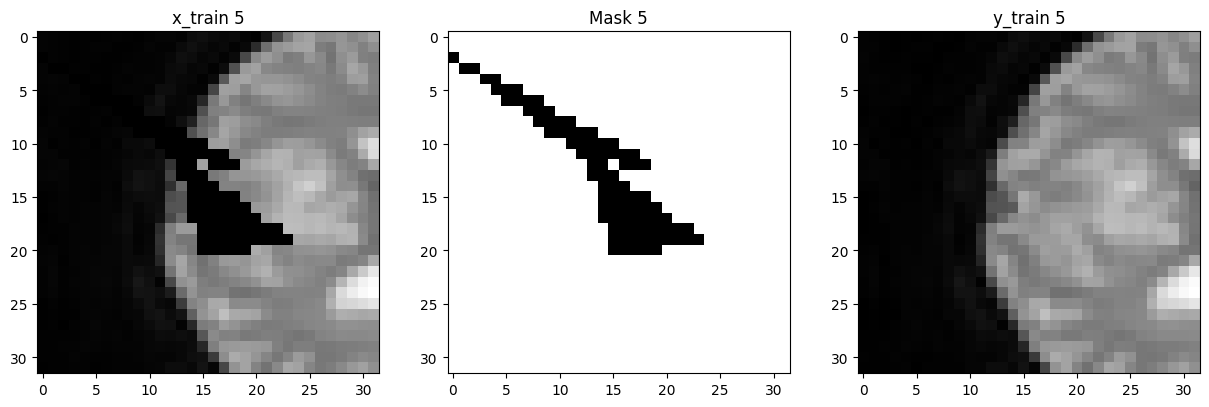

In [ ]:
from re import X
import matplotlib.pyplot as plt
import random

# Set the number of samples you want to show
num_samples = 5

# Get random indices
indices = random.sample(range(len(X_train)), num_samples)

# Loop over each index and plot the x_train, mask, and y_train
for i, index in enumerate(indices, start=1):
    # Get the x_train, mask, and y_train of the index
    x_train_sample = X_train[index]
    mask_sample = masks_train[index]
    y_train_sample = y_train[index]

    # Display the x_train, mask, and y_train
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(x_train_sample, cmap='gray')
    axes[0].set_title(f'x_train {i}')

    axes[1].imshow(mask_sample, cmap='gray')
    axes[1].set_title(f'Mask {i}')

    axes[2].imshow(y_train_sample, cmap='gray')
    axes[2].set_title(f'y_train {i}')

    plt.show()


# Neural Network Part

## Partial convolutional layer

In [ ]:

from tensorflow.keras import backend as K
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import Conv2D


class PConv2D(Conv2D):
    def __init__(self, *args, n_channels=3, mono=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_spec = [InputSpec(ndim=4), InputSpec(ndim=4)]

    def build(self, input_shape):
        """Adapted from original _Conv() layer of Keras
        param input_shape: list of dimensions for [img, mask]
        """

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        if input_shape[0][channel_axis] is None:
            raise ValueError('The channel dimension of the inputs should be defined. Found `None`.')

        self.input_dim = input_shape[0][channel_axis]

        # Image kernel
        kernel_shape = self.kernel_size + (self.input_dim, self.filters)
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='img_kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        # Mask kernel
        self.kernel_mask = K.ones(shape=self.kernel_size + (self.input_dim, self.filters))

        # Calculate padding size to achieve zero-padding
        self.pconv_padding = (
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)),
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)),
        )

        # Window size - used for normalization
        self.window_size = self.kernel_size[0] * self.kernel_size[1]

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs, mask=None):
        '''
        We will be using the Keras conv2d method, and essentially we have
        to do here is multiply the mask with the input X, before we apply the
        convolutions. For the mask itself, we apply convolutions with all weights
        set to 1.
        Subsequently, we clip mask values to between 0 and 1
        '''

        # Both image and mask must be supplied
        if type(inputs) is not list or len(inputs) != 2:
            raise Exception('PartialConvolution2D must be called on a list of two tensors [img, mask]. Instead got: ' + str(inputs))

        # Padding done explicitly so that padding becomes part of the masked partial convolution
        images = K.spatial_2d_padding(inputs[0], self.pconv_padding, self.data_format)
        masks = K.spatial_2d_padding(inputs[1], self.pconv_padding, self.data_format)

        # Apply convolutions to mask
        mask_output = K.conv2d(
            masks, self.kernel_mask,
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        # Apply convolutions to image
        img_output = K.conv2d(
            (images*masks), self.kernel,
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        # Calculate the mask ratio on each pixel in the output mask
        mask_ratio = self.window_size / (mask_output + 1e-8)

        # Clip output to be between 0 and 1
        mask_output = K.clip(mask_output, 0, 1)

        # Remove ratio values where there are holes
        mask_ratio = mask_ratio * mask_output

        # Normalize iamge output
        img_output = img_output * mask_ratio

        # Apply bias only to the image (if chosen to do so)
        if self.use_bias:
            img_output = K.bias_add(
                img_output,
                self.bias,
                data_format=self.data_format)

        # Apply activations on the image
        if self.activation is not None:
            img_output = self.activation(img_output)

        return [img_output, mask_output]

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[0][1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0][0],) + tuple(new_space) + (self.filters,)
            return [new_shape, new_shape]
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0], self.filters) + tuple(new_space)
            return [new_shape, new_shape]


def conv_output_length(input_length, filter_size,
                       padding, stride, dilation=1):
    """Determines output length of a convolution given input length.
    # Arguments
        input_length: integer.
        filter_size: integer.
        padding: one of `"same"`, `"valid"`, `"full"`.
        stride: integer.
        dilation: dilation rate, integer.
    # Returns
        The output length (integer).
    """
    if input_length is None:
        return None
    assert padding in {'same', 'valid', 'full', 'causal'}
    dilated_filter_size = (filter_size - 1) * dilation + 1
    if padding == 'same':
        output_length = input_length
    elif padding == 'valid':
        output_length = input_length - dilated_filter_size + 1
    elif padding == 'causal':
        output_length = input_length
    elif padding == 'full':
        output_length = input_length + dilated_filter_size - 1
    return (output_length + stride - 1) // stride

##U-Net

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization,Activation

from tensorflow.keras.layers import Layer

class RestorationLayer(Layer):
    def __init__(self, **kwargs):
        super(RestorationLayer, self).__init__(**kwargs)

    def call(self, inputs):
        model_output, original_image, mask = inputs

        output_unmasked = model_output * (1 - mask)
        output_masked = original_image * mask
        final_output = output_unmasked + output_masked

        return final_output



def create_model():
    inputs = Input((32, 32, 1))
    # original_image = Input((32, 32, 1))
    # mask = Input((32, 32, 1))


    # encoder
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # middle
    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    # decoder
    up1 = UpSampling2D(size=(2, 2))(conv5)
    up1 = concatenate([conv4, up1], axis=-1)
    conv6 = Conv2D(512, (3, 3), padding='same')(up1)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    up2 = UpSampling2D(size=(2, 2))(conv6)
    up2 = concatenate([conv3, up2], axis=-1)
    conv7 = Conv2D(256, (3, 3), padding='same')(up2)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    up3 = UpSampling2D(size=(2, 2))(conv7)
    up3 = concatenate([conv2, up3], axis=-1)
    conv8 = Conv2D(128, (3, 3), padding='same')(up3)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)

    up4 = UpSampling2D(size=(2, 2))(conv8)
    up4 = concatenate([conv1, up4], axis=-1)
    conv9 = Conv2D(64, (3, 3), padding='same')(up4)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)

    # output layer
    conv10 = Conv2D(1, (1, 1), activation='sigmoid',padding='same')(conv9)
    # restored_image = RestorationLayer()([conv10, original_image, mask])

    # model = Model(inputs=[inputs, original_image, mask], outputs=[restored_image])
    model = Model(inputs=inputs,outputs=conv10)

    return model

model = create_model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   640         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 64)   0           ['batch_normalization[0][0]']

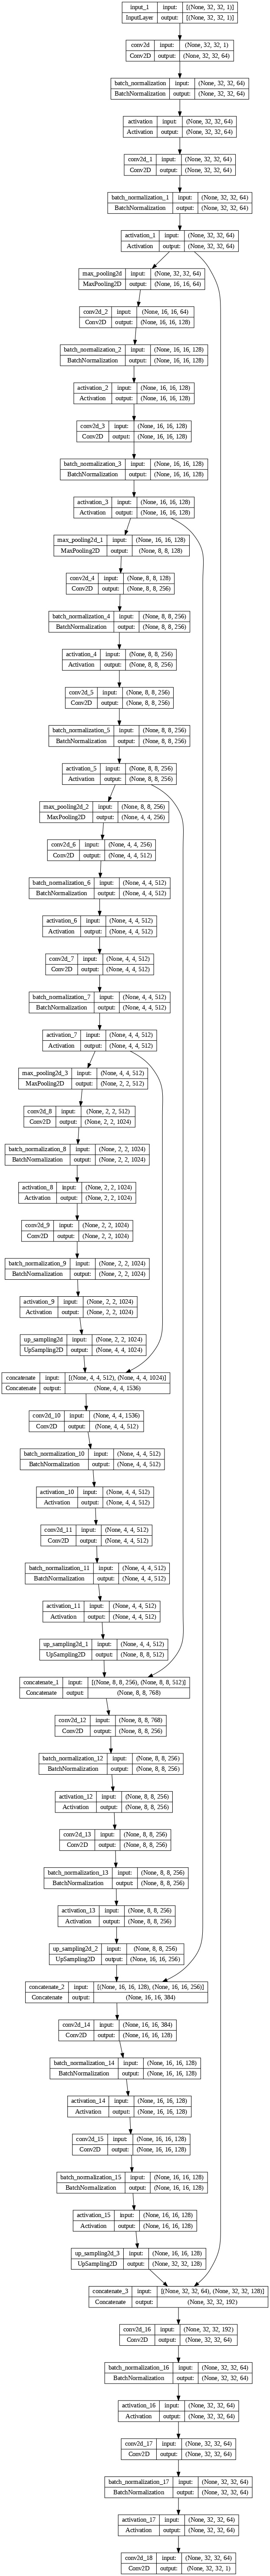

In [ ]:
import keras

keras.backend.clear_session()
model.compile(optimizer='adam', loss='mean_absolute_error')
keras.utils.plot_model(model, show_shapes=True, dpi=76)



In [ ]:
# import numpy as np
# from sklearn.model_selection import train_test_split

# new_dataset1 = np.expand_dims(new_dataset, axis=-1)
# labels1 = np.expand_dims(labels, axis=-1)
# masks1 = np.expand_dims(masks, axis=-1)

# X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(new_dataset1, labels1, masks1, test_size=0.2, random_state=42)

## PConv U-Net (deprecate)

In [ ]:
# from keras.models import Model
# from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization,Activation

# from tensorflow.keras.layers import Layer

# # class RestorationLayer(Layer):
# #     def __init__(self, **kwargs):
# #         super(RestorationLayer, self).__init__(**kwargs)

# #     def call(self, inputs):
# #         model_output, original_image, mask = inputs

# #         output_unmasked = model_output * (1 - mask)
# #         output_masked = original_image * mask
# #         final_output = output_unmasked + output_masked

# #         return final_output

# def create_model():
#     inputs = Input((32, 32, 1))
#     # original_image = Input((32, 32, 1))
#     mask = Input((32, 32, 1))

#     # encoder
#     conv1_1, mask1_1 = PConv2D(64, (3, 3), strides=1, padding='same')([inputs, mask])
#     conv1_1 = BatchNormalization()(conv1_1)
#     conv1_1 = Activation('relu')(conv1_1)
#     conv1_2, mask1_2 = PConv2D(64, (3, 3), strides=2, padding='same')([conv1_1, mask1_1])
#     conv1_2 = BatchNormalization()(conv1_2)
#     conv1_2 = Activation('relu')(conv1_2)
#     #pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2_1, mask2_1 = PConv2D(128, (3, 3), strides=1, padding='same')([conv1_2, mask1_2])
#     conv2_1 = BatchNormalization()(conv2_1)
#     conv2_1 = Activation('relu')(conv2_1)
#     conv2_2, mask2_2 = PConv2D(128, (3, 3), strides=2, padding='same')([conv2_1, mask2_1])
#     conv2_2 = BatchNormalization()(conv2_2)
#     conv2_2 = Activation('relu')(conv2_2)
#     #pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3_1, mask3_1 = PConv2D(256, (3, 3), strides=1, padding='same')([conv2_2, mask2_2])
#     conv3_1 = BatchNormalization()(conv3_1)
#     conv3_1 = Activation('relu')(conv3_1)
#     conv3_2, mask3_2 = PConv2D(256, (3, 3), strides=2, padding='same')([conv3_1, mask3_1])
#     conv3_2 = BatchNormalization()(conv3_2)
#     conv3_2 = Activation('relu')(conv3_2)
#     #pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#     conv4_1, mask4_1 = PConv2D(512, (3, 3), strides=1, padding='same')([conv3_2, mask3_2])
#     conv4_1 = BatchNormalization()(conv4_1)
#     conv4_1 = Activation('relu')(conv4_1)
#     conv4_2, mask4_2 = PConv2D(512, (3, 3), strides=2, padding='same')([conv4_1, mask4_1])
#     conv4_2 = BatchNormalization()(conv4_2)
#     conv4_2 = Activation('relu')(conv4_2)
#     #pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

#     # # middle
#     # conv5_1, mask5_1 = PConv2D(1024, (3, 3), strides=1, padding='same')([conv4_2, mask4_2])
#     # conv5_1 = BatchNormalization()(conv5_1)
#     # conv5_1 = Activation('relu')(conv5_1)
#     # conv5_2, mask5_2 = PConv2D(1024, (3, 3), strides=1, padding='same')([conv5_1, mask5_1])
#     # conv5_2 = BatchNormalization()(conv5_2)
#     # conv5_2 = Activation('relu')(conv5_2)


#     # decoder
#     up1 = UpSampling2D(size=(2, 2))(conv4_2)
#     mask_up1 = UpSampling2D(size=(2, 2))(mask4_2)
#     up1 = concatenate([conv4_1, up1], axis=-1)
#     mask_up1 = concatenate([mask4_1, mask_up1], axis=-1)
#     conv6_1, mask6_1 = PConv2D(512, (3, 3), strides=1, padding='same')([up1, mask_up1])
#     conv6_1 = BatchNormalization()(conv6_1)
#     conv6_1 = Activation('relu')(conv6_1)
#     conv6_2, mask6_2 = PConv2D(512, (3, 3), strides=1, padding='same')([conv6_1, mask6_1])
#     conv6_2 = BatchNormalization()(conv6_2)
#     conv6_2 = Activation('relu')(conv6_2)

#     up2 = UpSampling2D(size=(2, 2))(conv6_2)
#     mask_up2 = UpSampling2D(size=(2, 2))(mask6_2)
#     up2 = concatenate([conv3_1, up2], axis=-1)
#     mask_up2 = concatenate([mask3_1, mask_up2], axis=-1)
#     conv7_1, mask7_1 = PConv2D(256, (3, 3), padding='same')([up2, mask_up2])
#     conv7_1 = BatchNormalization()(conv7_1)
#     conv7_1 = Activation('relu')(conv7_1)
#     conv7_2, mask7_2 = PConv2D(256, (3, 3), padding='same')([conv7_1, mask7_1])
#     conv7_2 = BatchNormalization()(conv7_2)
#     conv7_2 = Activation('relu')(conv7_2)

#     up3 = UpSampling2D(size=(2, 2))(conv7_2)
#     mask_up3 = UpSampling2D(size=(2, 2))(mask7_2)
#     up3 = concatenate([conv2_1, up3], axis=-1)
#     mask_up3 = concatenate([mask2_1, mask_up3], axis=-1)
#     conv8_1, mask8_1 = PConv2D(128, (3, 3), padding='same')([up3, mask_up3])
#     conv8_1 = BatchNormalization()(conv8_1)
#     conv8_1 = Activation('relu')(conv8_1)
#     conv8_2, mask8_2 = PConv2D(128, (3, 3), padding='same')([conv8_1, mask8_1])
#     conv8_2 = BatchNormalization()(conv8_2)
#     conv8_2 = Activation('relu')(conv8_2)

#     up4 = UpSampling2D(size=(2, 2))(conv8_2)
#     mask_up4 = UpSampling2D(size=(2, 2))(mask8_2)
#     up4 = concatenate([conv1_1, up4], axis=-1)
#     mask_up4 = concatenate([mask1_1, mask_up4], axis=-1)
#     conv9_1, mask9_1 = PConv2D(64, (3, 3), padding='same')([up4, mask_up4])
#     conv9_1 = BatchNormalization()(conv9_1)
#     conv9_1 = Activation('relu')(conv9_1)
#     conv9_2, mask9_2 = PConv2D(64, (3, 3), padding='same')([conv9_1, mask9_1])
#     conv9_2 = BatchNormalization()(conv9_2)
#     conv9_2 = Activation('relu')(conv9_2)

#     # output layer
#     conv10 = Conv2D(1, (1, 1), activation='sigmoid',padding='same')(conv9_2)
#     # restored_image = RestorationLayer()([conv10, original_image, mask])

#     # model = Model(inputs=[inputs, original_image, mask], outputs=[restored_image])
#     model = Model(inputs=[inputs, mask], outputs=conv10)

#     return model

# model = create_model()
# model.summary()





Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 p_conv2d (PConv2D)             [(None, 32, 32, 64)  1216        ['input_1[0][0]',                
                                , (None, 32, 32, 64               'input_2[0][0]']                
                                )]                                                                
                                                                                              

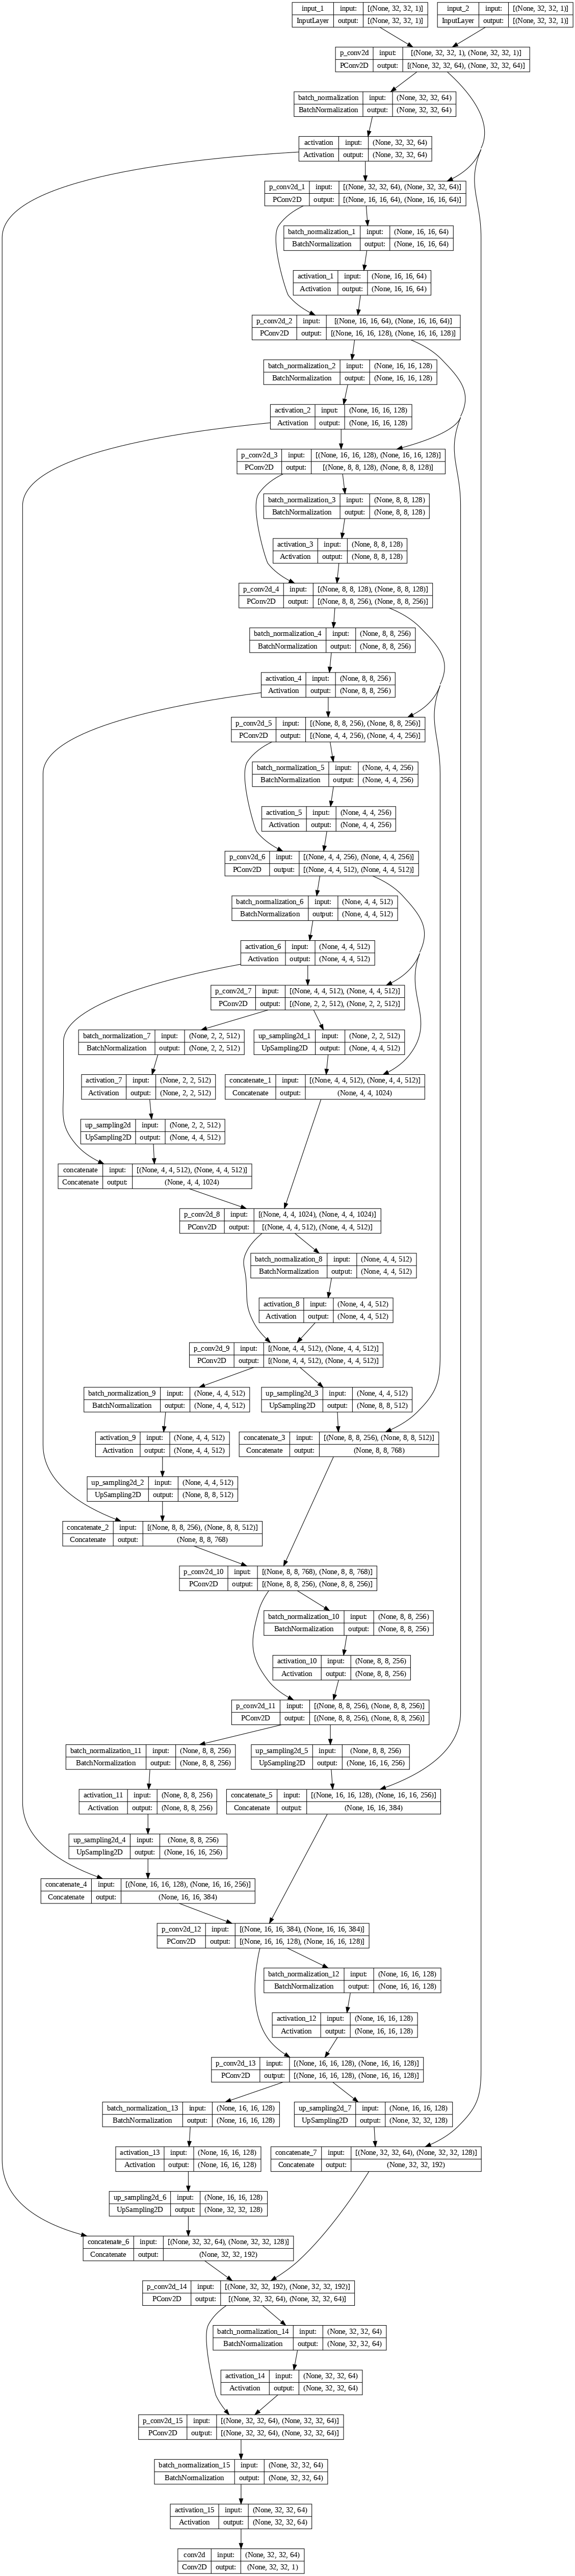

In [ ]:
# import keras

# keras.backend.clear_session()
# model.compile(optimizer='adam', loss='mse')
# keras.utils.plot_model(model, show_shapes=True, dpi=76)



##PConv U-Net


In [ ]:

import keras

class InpaintingModel:

  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(32,32,1)):
    input_image = keras.layers.Input(input_size)
    input_mask = keras.layers.Input(input_size, name='encoder_input')

    conv1, mask1, conv2, mask2 = self.__encoder_layer(32, input_image, input_mask, ['conv1', 'conv2'])
    conv3, mask3, conv4, mask4 = self.__encoder_layer(64, conv2, mask2, ['conv3', 'conv4'])
    conv5, mask5, conv6, mask6 = self.__encoder_layer(128, conv4, mask4, ['conv5', 'conv6'])
    conv7, mask7, conv8, mask8 = self.__encoder_layer(256, conv6, mask6, ['conv7', 'encoder_output'])

    conv9, mask9, conv10, mask10 = self.__decoder_layer(256, 128, conv8, mask8, conv7, mask7, ['conv9', 'conv10'])
    conv11, mask11, conv12, mask12 = self.__decoder_layer(128, 64, conv10, mask10, conv5, mask5, ['conv11', 'conv12'])
    conv13, mask13, conv14, mask14 = self.__decoder_layer(64, 32, conv12, mask12, conv3, mask3, ['conv13', 'conv14'])
    conv15, mask15, conv16, mask16 = self.__decoder_layer(32, 3, conv14, mask14, conv1, mask1, ['conv15', 'decoder_output'])

    outputs = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv16)


    model = keras.models.Model(inputs=[input_image, input_mask], outputs=outputs)
    return model

  def __encoder_layer(self, filters, in_layer, in_mask, names):
    conv1, mask1 = PConv2D(32, (3,3), strides=1, padding='same', name=names[0])([in_layer, in_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(32, (3,3), strides=2, padding='same', name=names[1])([conv1, mask1])
    conv2 = keras.layers.BatchNormalization()(conv2, training=True)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

  def __decoder_layer(self, filter1, filter2, in_img, in_mask, share_img, share_mask, names):
    up_img = keras.layers.UpSampling2D(size=(2,2))(in_img)
    up_mask = keras.layers.UpSampling2D(size=(2,2))(in_mask)
    concat_img = keras.layers.Concatenate(axis=3)([share_img, up_img])
    concat_mask = keras.layers.Concatenate(axis=3)([share_mask, up_mask])

    conv1, mask1 = PConv2D(filter1, (3,3), padding='same', name=names[0])([concat_img, concat_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(filter2, (3,3), padding='same', name=names[1])([conv1, mask1])
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2


## Plot function define

In [ ]:
def loss_curve(history):
  plt.figure()
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Training Loss and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  #plt.ylim([0,0.01])
  plt.legend()
  plt.show()

## Metrics

In [ ]:
def ssim_metrics(y_pred, y_test):
    def calculate_ssim(img1, img2):
        img1 = img_as_float(img1)
        img2 = img_as_float(img2)
        return ssim(img1, img2, channel_axis=0)


    y_pred = y_pred.squeeze()

    y_test_float = y_test.astype('float32')
    y_pred_float = y_pred.astype('float32')



    ssim_values = []
    for i in tqdm(range(len(y_test_float))):
        ssim_values.append(calculate_ssim(y_test_float[i], y_pred_float[i]))

    print('Average SSIM:', np.mean(ssim_values))


## U-Net mse

In [ ]:
model_unet_mse = create_model()
optimizer = Adam(learning_rate=0.001)
model_unet_mse.compile(optimizer=optimizer, loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_unet_mse.fit(X_train, y_train, epochs=30, batch_size=128, validation_split=0.2, callbacks=[early_stop])

Epoch 1/30
168/168 [==============================] - 29s 158ms/step - loss: 0.0054 - val_loss: 0.0622
Epoch 2/30
168/168 [==============================] - 26s 155ms/step - loss: 0.0023 - val_loss: 0.0508
Epoch 3/30
168/168 [==============================] - 26s 153ms/step - loss: 0.0021 - val_loss: 0.0350
Epoch 4/30
168/168 [==============================] - 26s 153ms/step - loss: 0.0018 - val_loss: 0.0060
Epoch 5/30
168/168 [==============================] - 26s 154ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 6/30
168/168 [==============================] - 26s 153ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 7/30
168/168 [==============================] - 26s 153ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 8/30
168/168 [==============================] - 26s 153ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 9/30
168/168 [==============================] - 26s 153ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 10/30
168/168 [==============================] - 26s 153ms/step - l

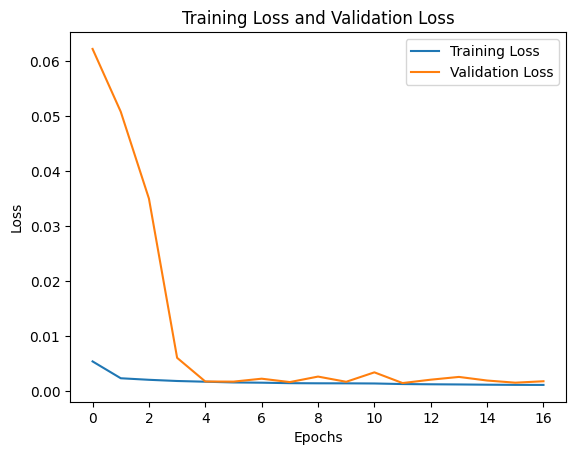

In [ ]:
loss_curve(history)

1/1 [==============================] - 0s 24ms/step


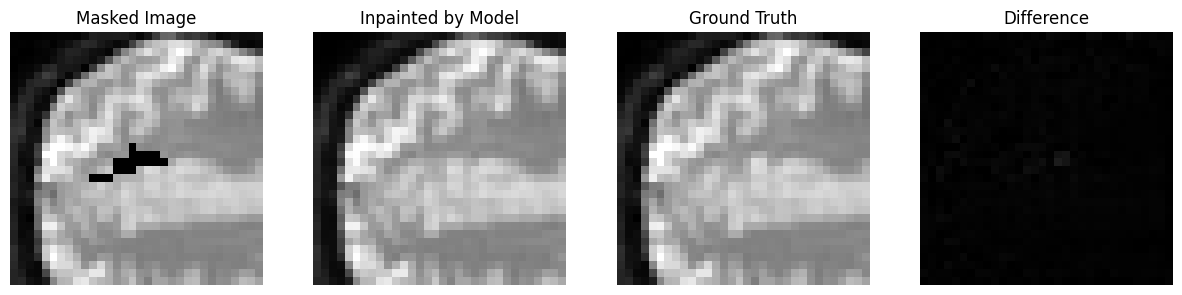

1/1 [==============================] - 0s 23ms/step


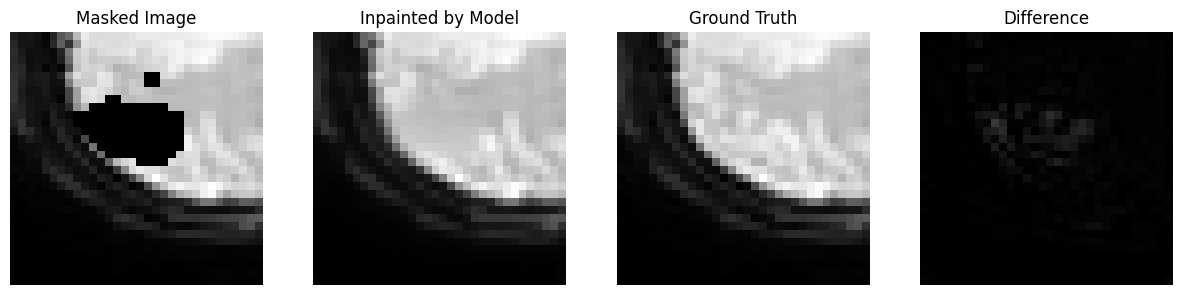

1/1 [==============================] - 0s 24ms/step


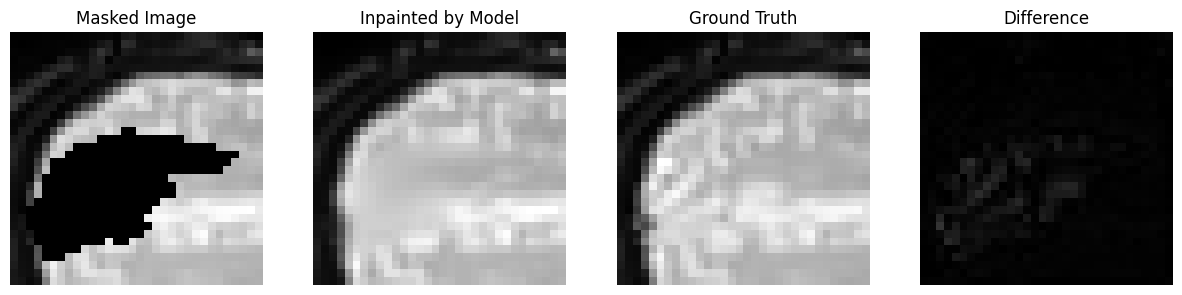

1/1 [==============================] - 0s 22ms/step


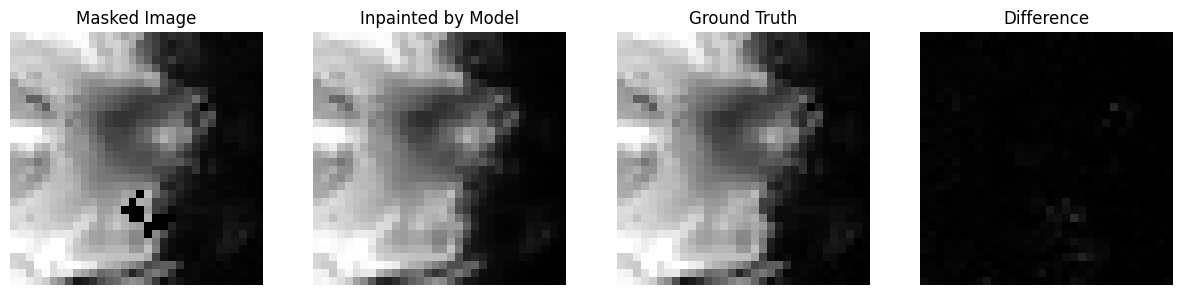

1/1 [==============================] - 0s 22ms/step


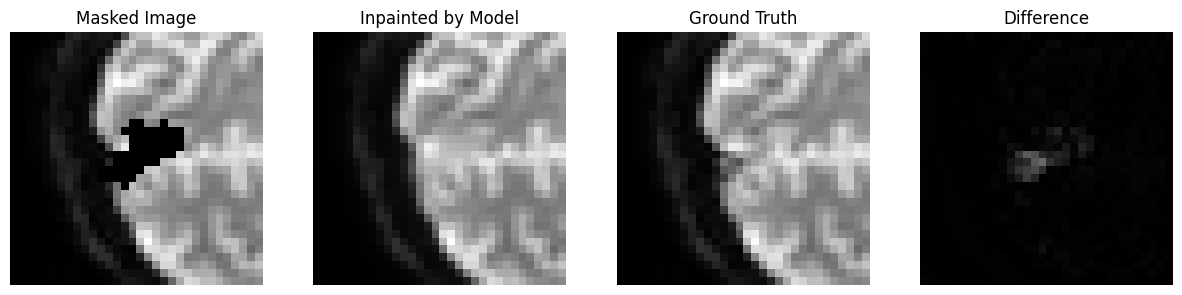

1/1 [==============================] - 0s 23ms/step


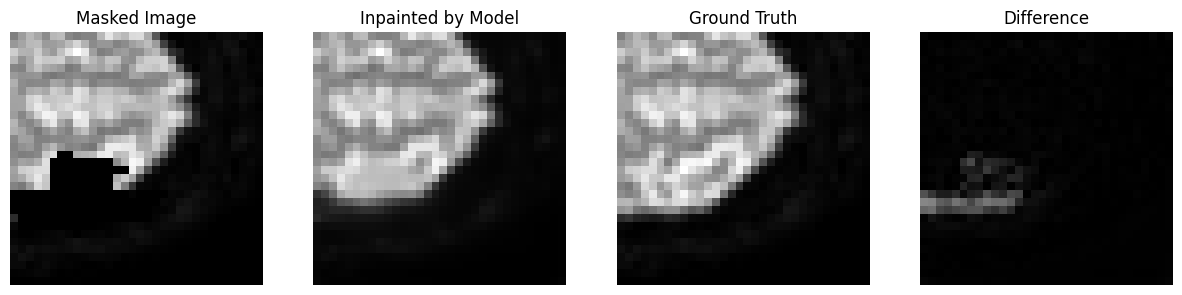

1/1 [==============================] - 0s 21ms/step


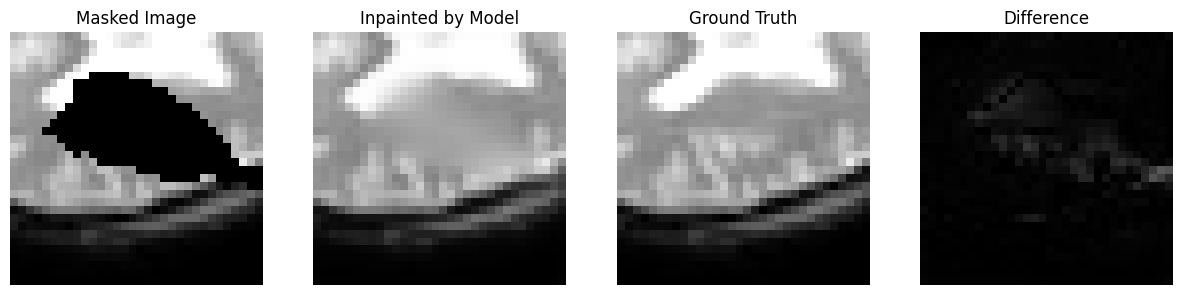

1/1 [==============================] - 0s 23ms/step


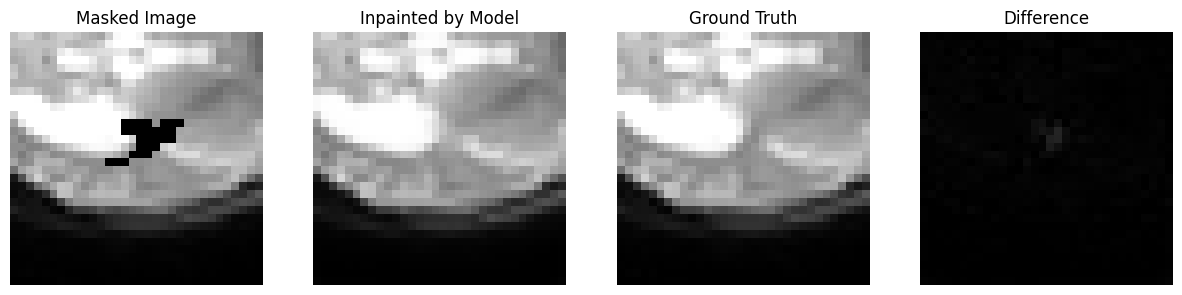

1/1 [==============================] - 0s 22ms/step


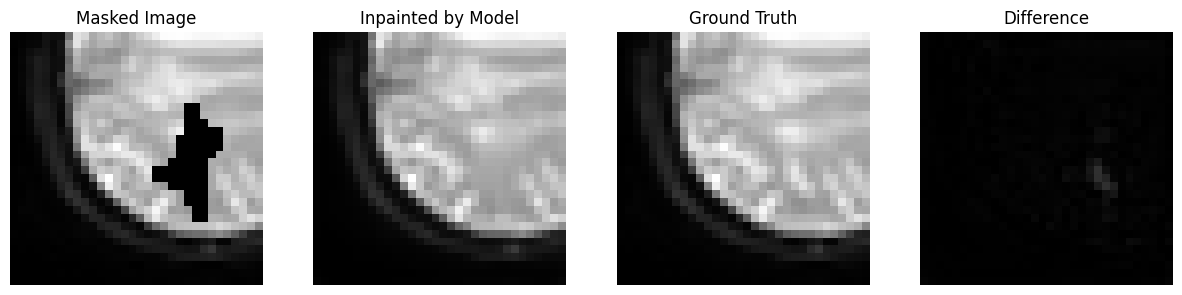

1/1 [==============================] - 0s 22ms/step


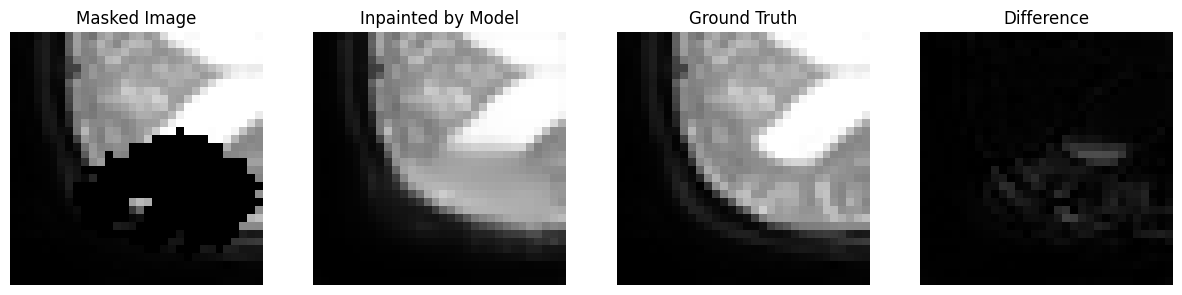

In [ ]:
np.random.seed(11)
num_images_to_show = 10

for i in range(num_images_to_show):
    img_index = np.random.randint(len(X_test))  # Use the length of your dataset

    masked_image = X_test[img_index]
    original_image = y_test[img_index]
    mask = masks_test[img_index]
    prediction = model_unet_mse.predict([masked_image[np.newaxis, ...]])[0]

    difference = np.abs(prediction.squeeze() - original_image)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(masked_image.squeeze(), cmap='gray')
    plt.title('Masked Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.title('Inpainted by Model')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(difference.squeeze(), cmap='gray',vmin=0,vmax=1)
    plt.title('Difference')
    plt.axis('off')

    plt.show()

## PConv U-Net mse

In [ ]:
inpainting_model = InpaintingModel()
model_pconv_unet_mse = inpainting_model.prepare_model()


adam = keras.optimizers.Adam(learning_rate=0.001)
model_pconv_unet_mse.compile(optimizer=adam, loss='mse')


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_pconv_unet_mse.fit([X_train, masks_train], y_train, epochs=30, batch_size=128, validation_split=0.2, callbacks=[early_stop])


Epoch 1/30
168/168 [==============================] - 20s 93ms/step - loss: 0.0368 - val_loss: 0.0660
Epoch 2/30
168/168 [==============================] - 14s 86ms/step - loss: 0.0069 - val_loss: 0.0300
Epoch 3/30
168/168 [==============================] - 14s 85ms/step - loss: 0.0054 - val_loss: 0.0121
Epoch 4/30
168/168 [==============================] - 14s 84ms/step - loss: 0.0045 - val_loss: 0.0056
Epoch 5/30
168/168 [==============================] - 14s 84ms/step - loss: 0.0039 - val_loss: 0.0058
Epoch 6/30
168/168 [==============================] - 14s 85ms/step - loss: 0.0035 - val_loss: 0.0044
Epoch 7/30
168/168 [==============================] - 14s 85ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 8/30
168/168 [==============================] - 14s 86ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 9/30
168/168 [==============================] - 14s 85ms/step - loss: 0.0030 - val_loss: 0.0038
Epoch 10/30
168/168 [==============================] - 14s 85ms/step - loss: 0.002

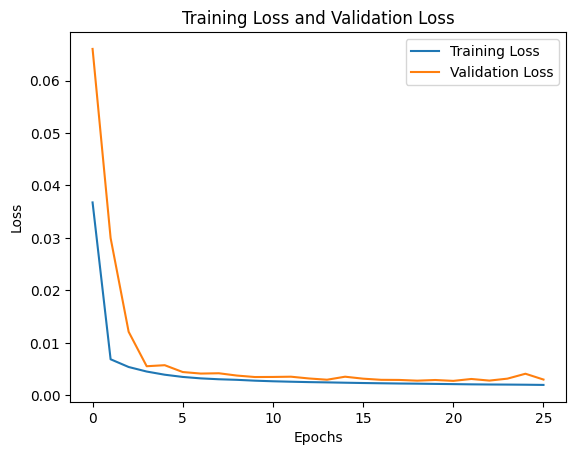

In [ ]:
loss_curve(history)

1/1 [==============================] - 0s 27ms/step


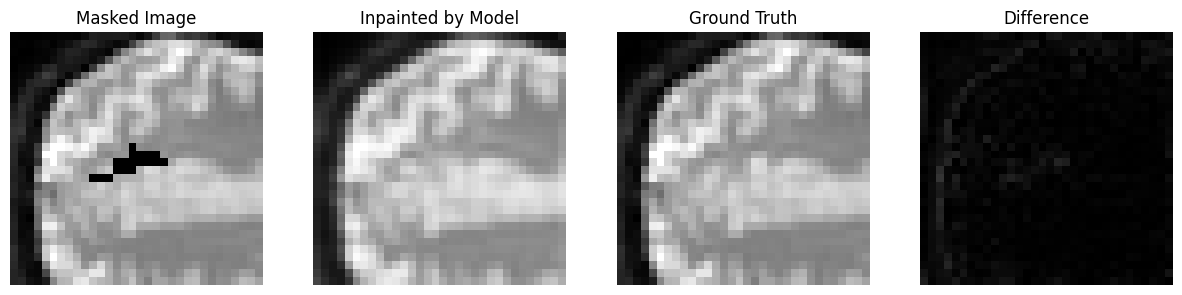

1/1 [==============================] - 0s 25ms/step


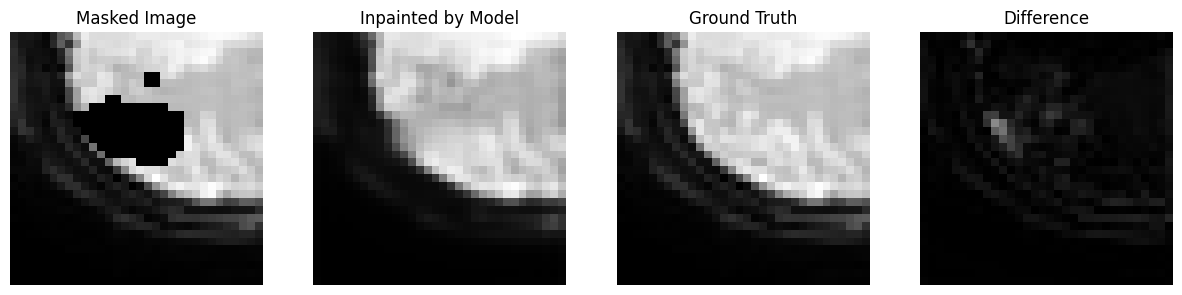

1/1 [==============================] - 0s 27ms/step


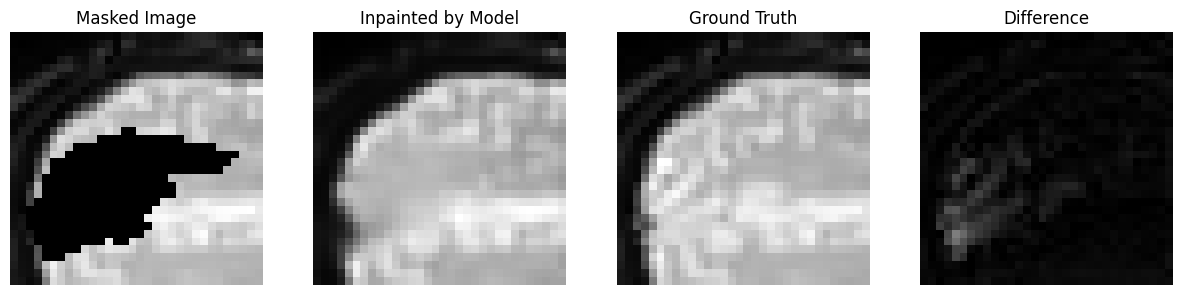

1/1 [==============================] - 0s 26ms/step


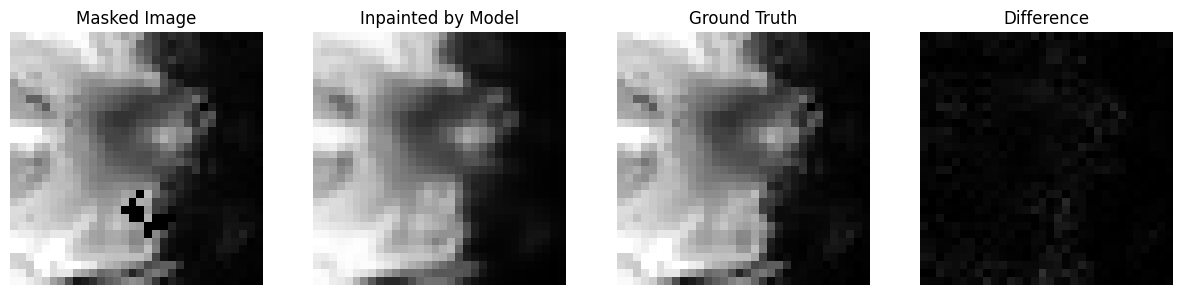

1/1 [==============================] - 0s 26ms/step


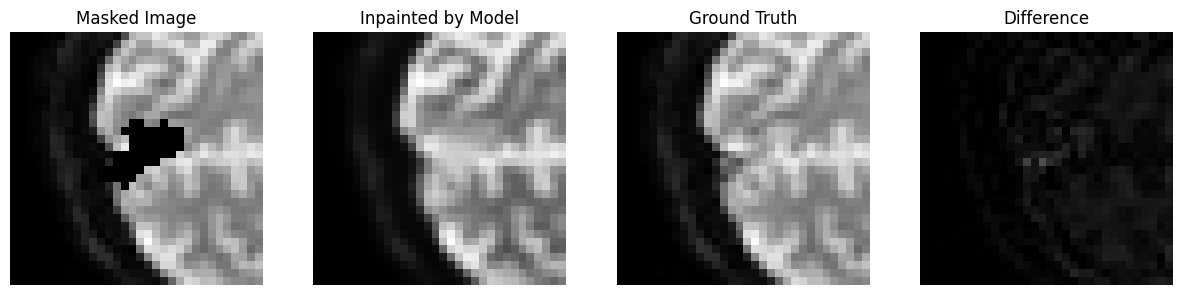

1/1 [==============================] - 0s 32ms/step


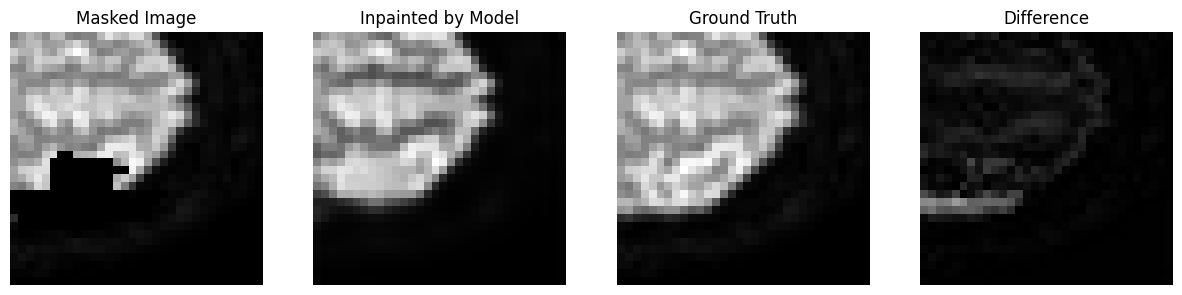

1/1 [==============================] - 0s 27ms/step


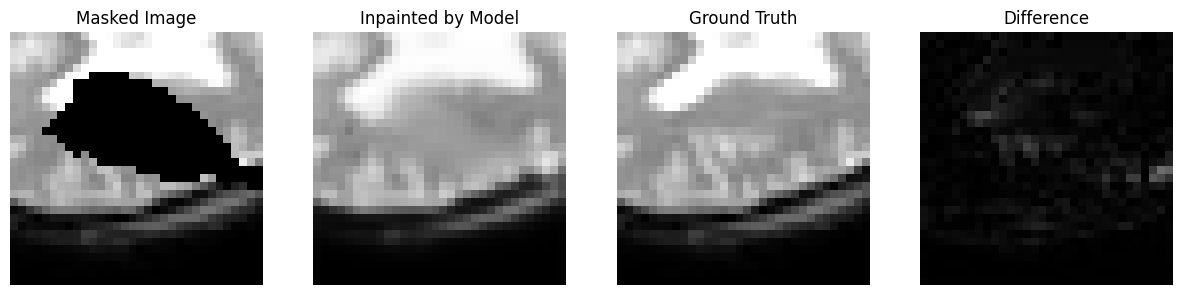

1/1 [==============================] - 0s 27ms/step


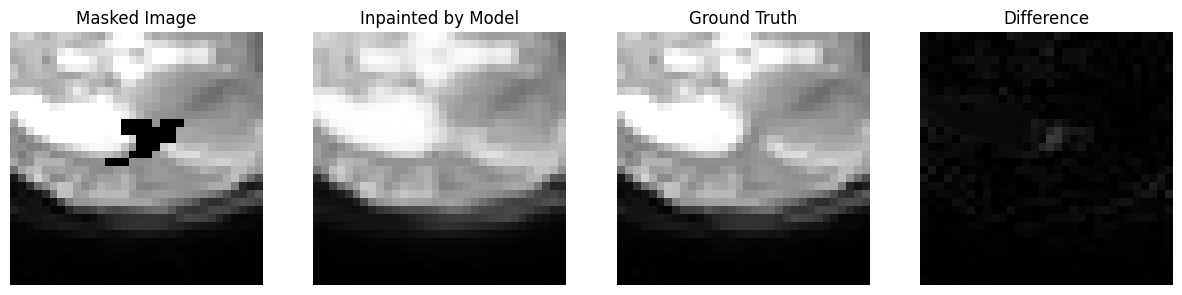

1/1 [==============================] - 0s 28ms/step


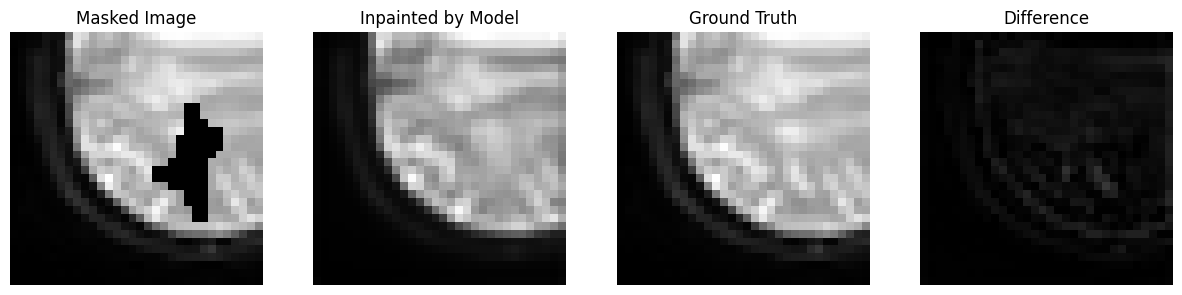

1/1 [==============================] - 0s 33ms/step


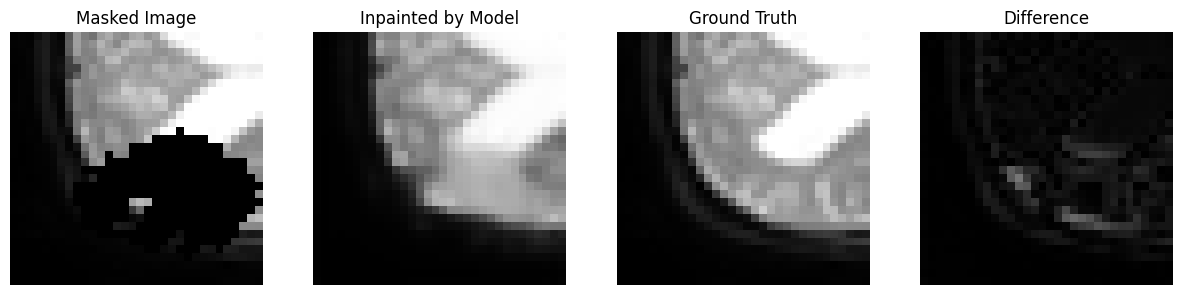

In [ ]:
np.random.seed(11)
num_images_to_show = 10

for i in range(num_images_to_show):
    img_index = np.random.randint(len(X_test))  # Use the length of your dataset

    masked_image = X_test[img_index]
    original_image = y_test[img_index]
    mask = masks_test[img_index]
    prediction = model_pconv_unet_mse.predict([masked_image[np.newaxis, ...], mask[np.newaxis, ...]])[0]

    difference = np.abs(prediction.squeeze() - original_image)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(masked_image.squeeze(), cmap='gray')
    plt.title('Masked Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.title('Inpainted by Model')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(difference.squeeze(), cmap='gray',vmin=0,vmax=1)
    plt.title('Difference')
    plt.axis('off')

    plt.show()

## PConv U-Net refinement mse + perceptual loss (Not finished yet)

In [ ]:
X_train_1 = model_pconv_unet_mse.predict([X_train, masks_train])
X_test_1 = model_pconv_unet_mse.predict([X_test, masks_test])

#X_train_1_expand = np.expand_dims(X_train_1, axis=-1)
masks_train_expand = np.expand_dims(masks_train, axis=-1)
y_train_expand = np.expand_dims(y_train, axis=-1)


#X_test_1_expand = np.expand_dims(X_test_1, axis=-1)
masks_test_expand = np.expand_dims(masks_test, axis=-1)
y_test_expand = np.expand_dims(y_test, axis=-1)

23/23 [==============================] - 0s 9ms/step


In [ ]:
X_train_1.shape

(26833, 32, 32, 1)

In [ ]:
masks_train_expand.shape

(26833, 32, 32, 1)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

# Load a pre-trained VGG model
vgg = VGG16(include_top=False, weights='imagenet')
loss_model_1 = Model(inputs=vgg.input, outputs=vgg.get_layer('block1_pool').output)
loss_model_1.trainable = False

loss_model_2 = Model(inputs=vgg.input, outputs=vgg.get_layer('block2_pool').output)
loss_model_2.trainable = False

loss_model_3 = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_pool').output)
loss_model_3.trainable = False

# Convert grayscale to RGB
def to_rgb(x):
    return K.concatenate([x, x, x], axis=-1)

def perceptual_loss(y_true, y_pred):
    # Convert images to RGB
    y_true_rgb = to_rgb(y_true)
    y_pred_rgb = to_rgb(y_pred)
    # Scale to [0, 255]
    y_true_rgb_scaled = y_true_rgb * 255.0
    y_pred_rgb_scaled = y_pred_rgb * 255.0
    # Preprocess the inputs
    y_true_rgb_preprocessed = preprocess_input(y_true_rgb_scaled)
    y_pred_rgb_preprocessed = preprocess_input(y_pred_rgb_scaled)
    return (1/3)*(K.mean(tf.abs(loss_model_1(y_true_rgb_scaled) - loss_model_1(y_pred_rgb_scaled))) + K.mean(tf.abs(loss_model_2(y_true_rgb_scaled) - loss_model_2(y_pred_rgb_scaled))) + K.mean(tf.abs(loss_model_3(y_true_rgb_scaled) - loss_model_3(y_pred_rgb_scaled))))


In [ ]:
inpainting_model = InpaintingModel()
model_pconv_unet_refinement = inpainting_model.prepare_model()


adam = keras.optimizers.Adam(learning_rate=0.001)
model_pconv_unet_refinement.compile(optimizer=adam, loss=perceptual_loss)


early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history = model_pconv_unet_refinement.fit([X_train_1, masks_train_expand], y_train_expand, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stop])

Epoch 1/100
336/336 [==============================] - 33s 80ms/step - loss: 226.9075 - val_loss: 264.8286
Epoch 2/100
336/336 [==============================] - 25s 74ms/step - loss: 131.0644 - val_loss: 260.8615
Epoch 3/100
336/336 [==============================] - 25s 73ms/step - loss: 116.4328 - val_loss: 244.9515
Epoch 4/100
336/336 [==============================] - 25s 74ms/step - loss: 108.2915 - val_loss: 229.9133
Epoch 5/100
336/336 [==============================] - 25s 73ms/step - loss: 102.9390 - val_loss: 185.8852
Epoch 6/100
336/336 [==============================] - 25s 73ms/step - loss: 98.3495 - val_loss: 201.7619
Epoch 7/100
336/336 [==============================] - 25s 73ms/step - loss: 95.4249 - val_loss: 210.1791
Epoch 8/100
336/336 [==============================] - 25s 75ms/step - loss: 92.6148 - val_loss: 164.2665
Epoch 9/100
336/336 [==============================] - 25s 73ms/step - loss: 90.6850 - val_loss: 255.1838
Epoch 10/100
336/336 [===================

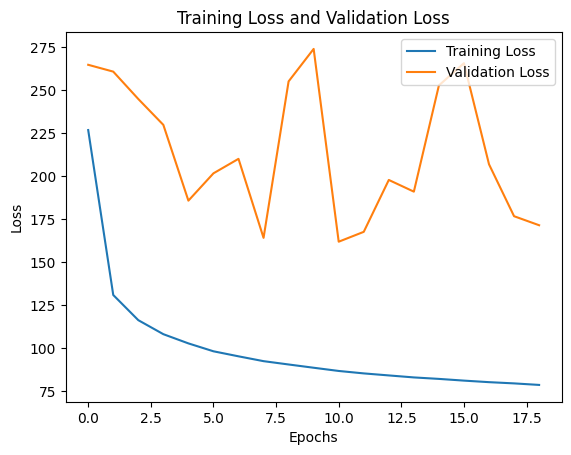

In [ ]:
loss_curve(history)

1/1 [==============================] - 0s 39ms/step


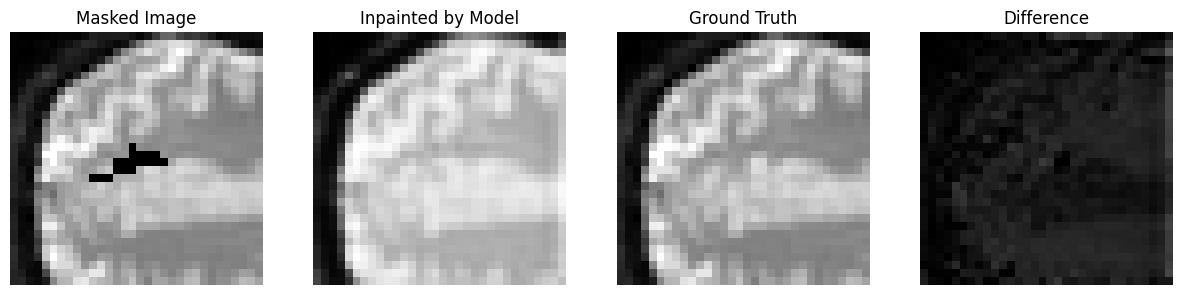

1/1 [==============================] - 0s 24ms/step


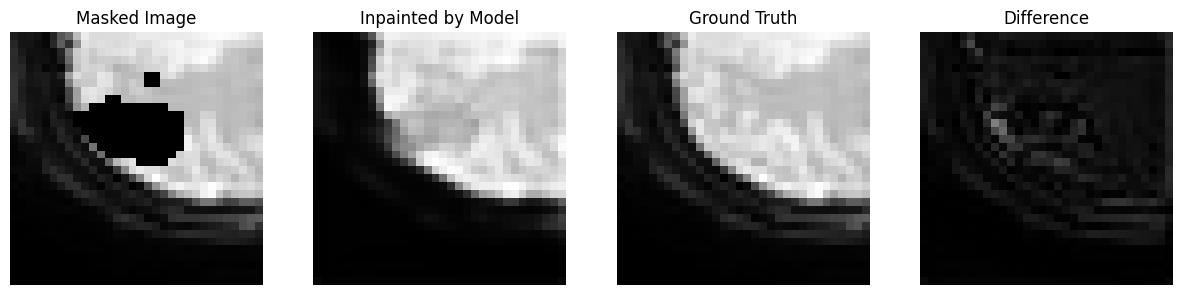

1/1 [==============================] - 0s 25ms/step


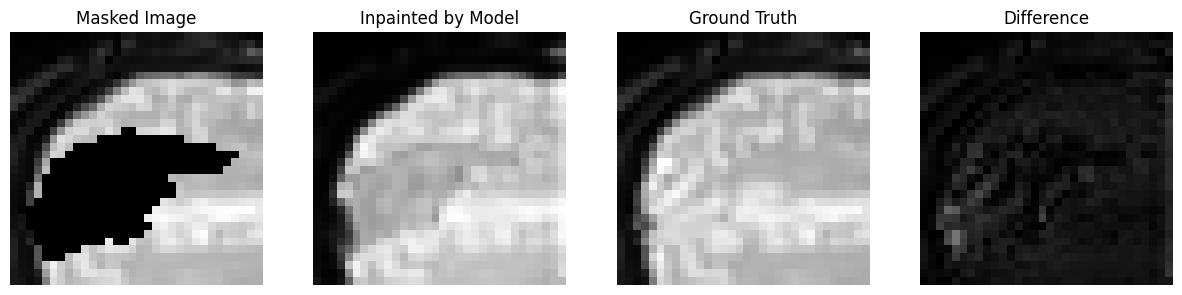

1/1 [==============================] - 0s 23ms/step


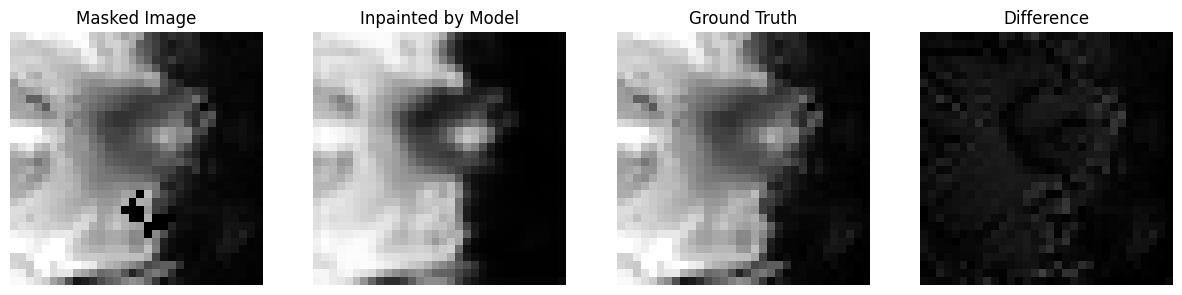

1/1 [==============================] - 0s 26ms/step


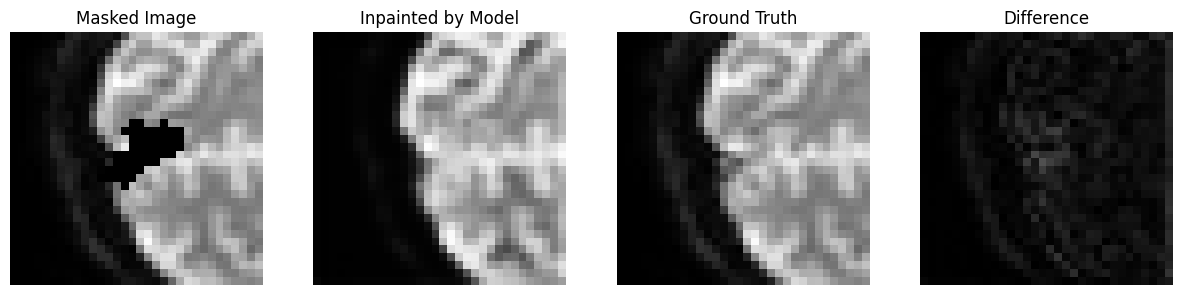

1/1 [==============================] - 0s 25ms/step


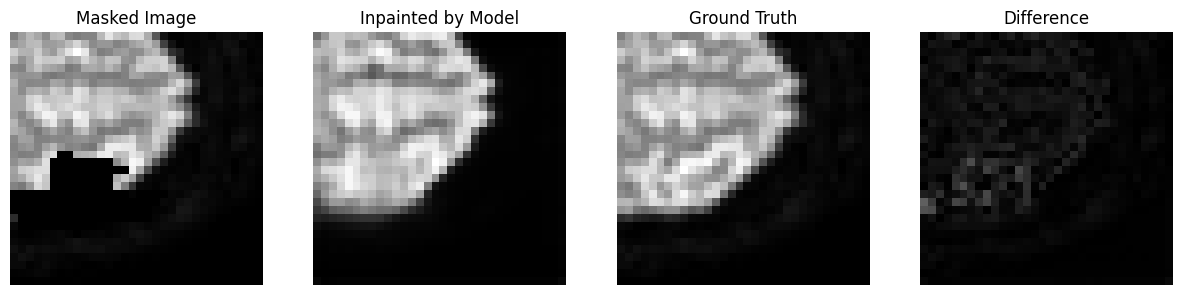

1/1 [==============================] - 0s 26ms/step


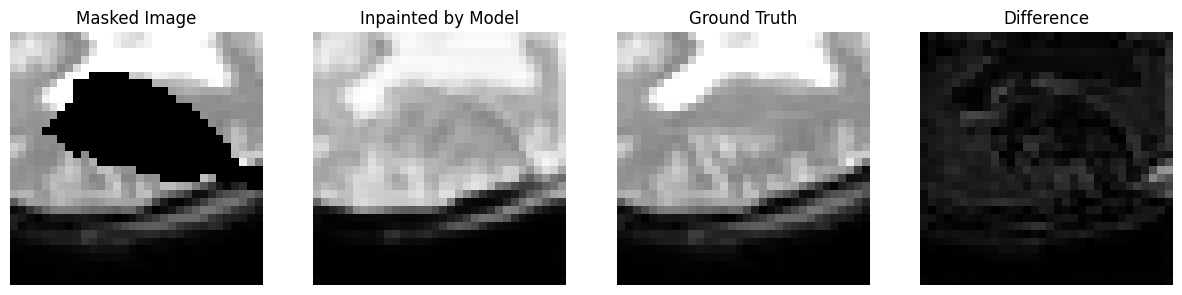

1/1 [==============================] - 0s 26ms/step


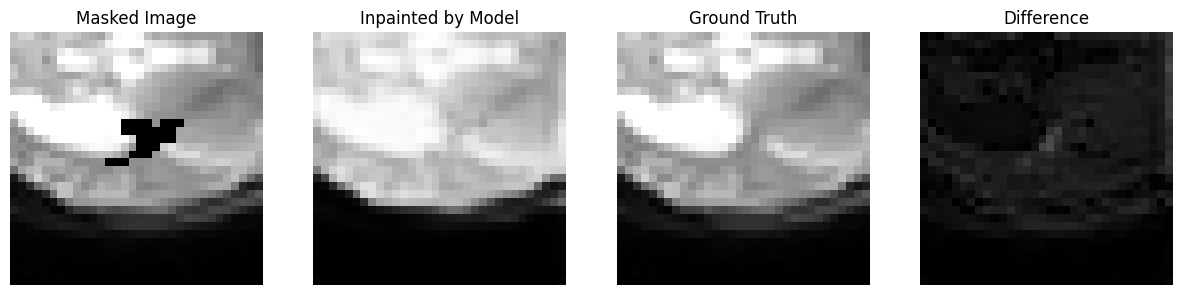

1/1 [==============================] - 0s 26ms/step


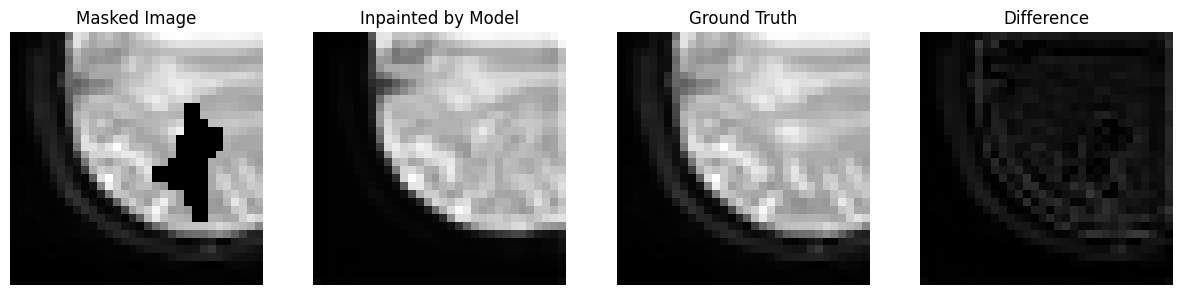

1/1 [==============================] - 0s 25ms/step


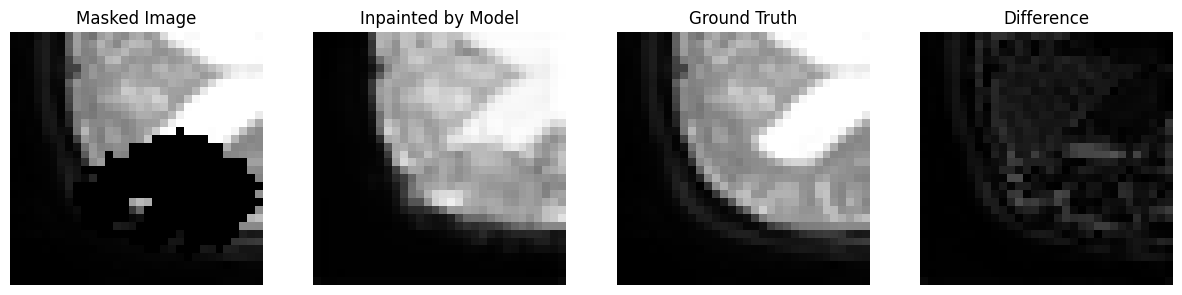

In [ ]:
import matplotlib.pyplot as plt

np.random.seed(11)
num_images_to_show = 10

for i in range(num_images_to_show):
    img_index = np.random.randint(len(X_test))  # Use the length of your dataset

    masked_image_1 = X_test[img_index]
    masked_image = X_test_1[img_index]
    original_image = y_test[img_index]
    mask = masks_test_expand[img_index]
    prediction = model_pconv_unet_refinement.predict([masked_image[np.newaxis, ...], mask[np.newaxis, ...]])[0]

    difference = np.abs(prediction.squeeze() - original_image)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(masked_image_1.squeeze(), cmap='gray')
    plt.title('Masked Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.title('Inpainted by Model')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(difference.squeeze(), cmap='gray',vmin=0,vmax=1)
    plt.title('Difference')
    plt.axis('off')

    plt.show()

##PConv U-Net combined loss

In [ ]:
X_train_expand = np.expand_dims(X_train, axis=-1)
masks_train_expand = np.expand_dims(masks_train, axis=-1)
y_train_expand = np.expand_dims(y_train, axis=-1)


y_train_concat = np.concatenate([masks_train_expand, y_train_expand], axis=-1)
X_test_expand = np.expand_dims(X_test, axis=-1)
masks_test_expand = np.expand_dims(masks_test, axis=-1)

### Losses

perceptual loss

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

# Load a pre-trained VGG model
vgg = VGG16(include_top=False, weights='imagenet')
loss_model_1 = Model(inputs=vgg.input, outputs=vgg.get_layer('block1_pool').output)
loss_model_1.trainable = False

loss_model_2 = Model(inputs=vgg.input, outputs=vgg.get_layer('block2_pool').output)
loss_model_2.trainable = False

loss_model_3 = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_pool').output)
loss_model_3.trainable = False

# Convert grayscale to RGB
def to_rgb(x):
    return K.concatenate([x, x, x], axis=-1)

def perceptual_loss(y_true, y_pred):
    # Convert images to RGB
    y_true_rgb = to_rgb(y_true)
    y_pred_rgb = to_rgb(y_pred)
    # Scale to [0, 255]
    y_true_rgb_scaled = y_true_rgb * 255.0
    y_pred_rgb_scaled = y_pred_rgb * 255.0
    # Preprocess the inputs
    y_true_rgb_preprocessed = preprocess_input(y_true_rgb_scaled)
    y_pred_rgb_preprocessed = preprocess_input(y_pred_rgb_scaled)
    return (1/3)*(K.mean(tf.abs(loss_model_1(y_true_rgb_scaled) - loss_model_1(y_pred_rgb_scaled))) + K.mean(tf.abs(loss_model_2(y_true_rgb_scaled) - loss_model_2(y_pred_rgb_scaled))) + K.mean(tf.abs(loss_model_3(y_true_rgb_scaled) - loss_model_3(y_pred_rgb_scaled))))


style loss

In [ ]:
def gram_matrix(x):
    shape = tf.shape(x)
    batch = shape[0]
    h = shape[1]
    w = shape[2]
    ch = shape[3]
    features = tf.reshape(x, [batch, h * w, ch])
    gram = tf.matmul(features, features, transpose_a=True)
    return gram / tf.cast(ch * w * h, tf.float32)



def style_loss(y_true, y_pred):
    # Convert images to RGB
    y_true_rgb = to_rgb(y_true)
    y_pred_rgb = to_rgb(y_pred)
    # Preprocess the images
    y_true_rgb_preprocessed = preprocess_input(y_true_rgb * 255.0)
    y_pred_rgb_preprocessed = preprocess_input(y_pred_rgb * 255.0)
    # Get the VGG features
    y_true_features_1 = loss_model_1(y_true_rgb_preprocessed)
    y_pred_features_1 = loss_model_1(y_pred_rgb_preprocessed)
    y_true_features_2 = loss_model_2(y_true_rgb_preprocessed)
    y_pred_features_2 = loss_model_2(y_pred_rgb_preprocessed)
    y_true_features_3 = loss_model_3(y_true_rgb_preprocessed)
    y_pred_features_3 = loss_model_3(y_pred_rgb_preprocessed)
    # Get the Gram matrices
    y_true_gram_1 = gram_matrix(y_true_features_1)
    y_pred_gram_1 = gram_matrix(y_pred_features_1)
    y_true_gram_2 = gram_matrix(y_true_features_2)
    y_pred_gram_2 = gram_matrix(y_pred_features_2)
    y_true_gram_3 = gram_matrix(y_true_features_3)
    y_pred_gram_3 = gram_matrix(y_pred_features_3)
    # Compute the style loss
    return (1/3)*(K.mean(tf.abs(y_true_gram_1 - y_pred_gram_1)) + K.mean(tf.abs(y_true_gram_2 - y_pred_gram_2)) + K.mean(tf.abs(y_true_gram_3 - y_pred_gram_3)))


tv loss

In [ ]:
def tv_loss(y_pred):
    return tf.reduce_sum(tf.image.total_variation(y_pred))


### Train

In [ ]:
def total_loss(y_true, y_pred):
    mask = y_true[..., :1]
    y_true = y_true[..., 1:]

    y_comp = (1-mask)*y_pred + mask*y_true

    return   6*K.mean(tf.abs((1-mask)*(y_true - y_pred))) + K.mean(tf.abs((mask)*(y_true - y_pred))) + 0.05*perceptual_loss(y_true, y_pred) + 0.1*tv_loss(y_pred) + 120*style_loss(y_true,y_pred)


def mse_loss(y_true, y_pred):
    mask = y_true[..., :1]
    y_true = y_true[..., 1:]
    return  K.mean(K.square((y_true - y_pred)))

# input_img = keras.layers.Input((32,32,1))
# input_mask = keras.layers.Input((32,32,1))


inpainting_model = InpaintingModel()

model_pconv_total_loss = inpainting_model.prepare_model()

adam = keras.optimizers.Adam(learning_rate=0.001)
model_pconv_total_loss.compile(optimizer=adam, loss=total_loss)


early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history_1 = model_pconv_total_loss.fit([X_train_expand, masks_train_expand], y_train_concat, epochs=500, batch_size=32, validation_split=0.2, callbacks=[early_stop])



for layer in model_pconv_total_loss.layers:
    if isinstance(layer, keras.layers.BatchNormalization) and 'encoder' in layer.name:
        layer.trainable = False


adam = keras.optimizers.Adam(learning_rate=0.00025)
model_pconv_total_loss.compile(optimizer=adam, loss=total_loss)
history_2 = model_pconv_total_loss.fit([X_train_expand, masks_train_expand], y_train_concat, epochs=500, batch_size=32, validation_split=0.2, callbacks=[early_stop])

Epoch 1/500
671/671 [==============================] - 54s 68ms/step - loss: 75485.1562 - val_loss: 43986.7891
Epoch 2/500
671/671 [==============================] - 42s 63ms/step - loss: 27535.9707 - val_loss: 26989.7402
Epoch 3/500
671/671 [==============================] - 43s 64ms/step - loss: 22068.5605 - val_loss: 23196.2266
Epoch 4/500
671/671 [==============================] - 43s 63ms/step - loss: 19743.9023 - val_loss: 25906.1758
Epoch 5/500
671/671 [==============================] - 43s 63ms/step - loss: 18404.8457 - val_loss: 36685.4492
Epoch 6/500
671/671 [==============================] - 43s 63ms/step - loss: 17569.5156 - val_loss: 33762.1992
Epoch 7/500
671/671 [==============================] - 43s 63ms/step - loss: 16888.3828 - val_loss: 31842.0723
Epoch 8/500
671/671 [==============================] - 43s 63ms/step - loss: 16423.7793 - val_loss: 51694.6250
Epoch 9/500
671/671 [==============================] - 43s 63ms/step - loss: 16023.9795 - val_loss: 20334.4160
E

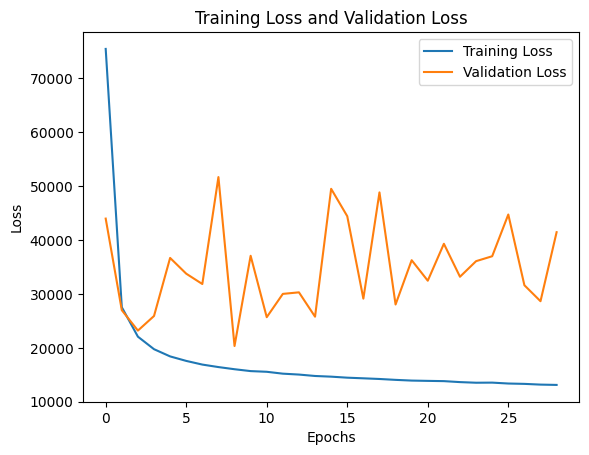

In [ ]:
loss_curve(history_1)

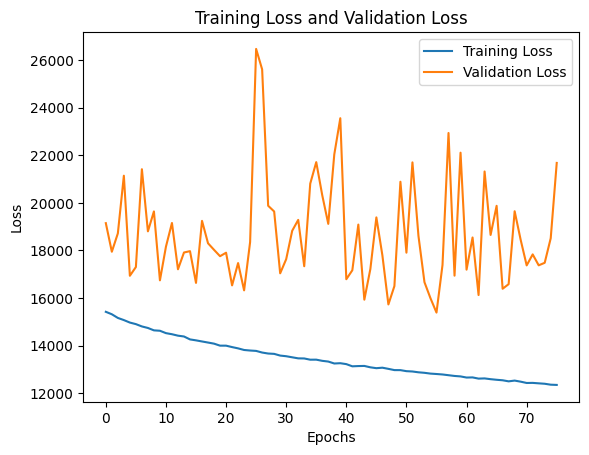

In [ ]:
loss_curve(history_2)

1/1 [==============================] - 1s 554ms/step


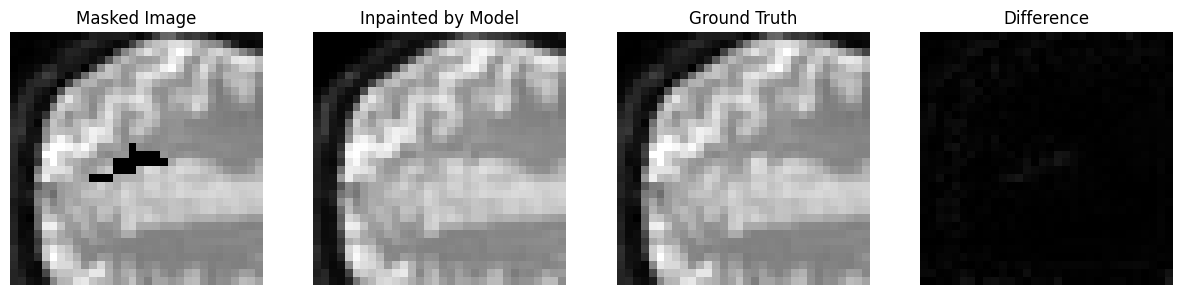

1/1 [==============================] - 0s 26ms/step


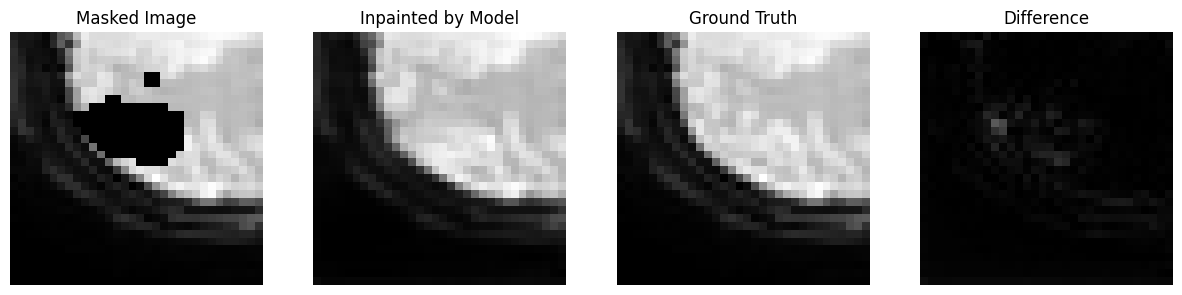

1/1 [==============================] - 0s 22ms/step


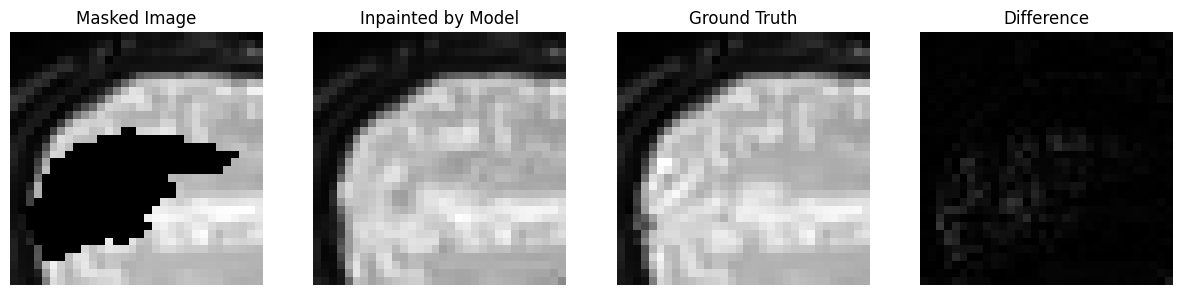

1/1 [==============================] - 0s 23ms/step


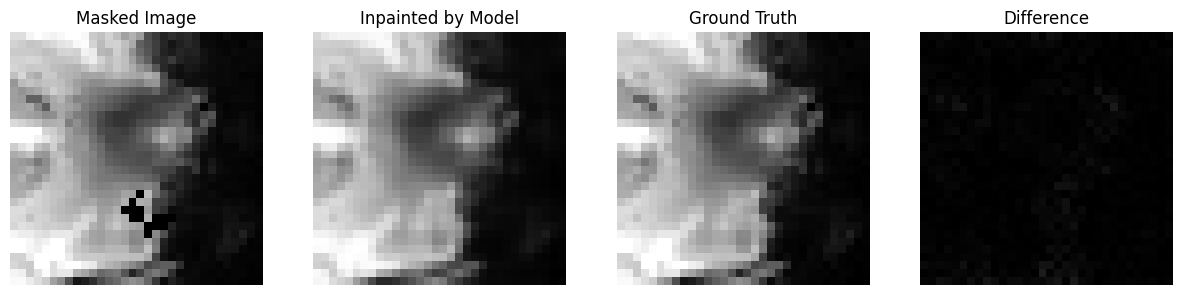

1/1 [==============================] - 0s 24ms/step


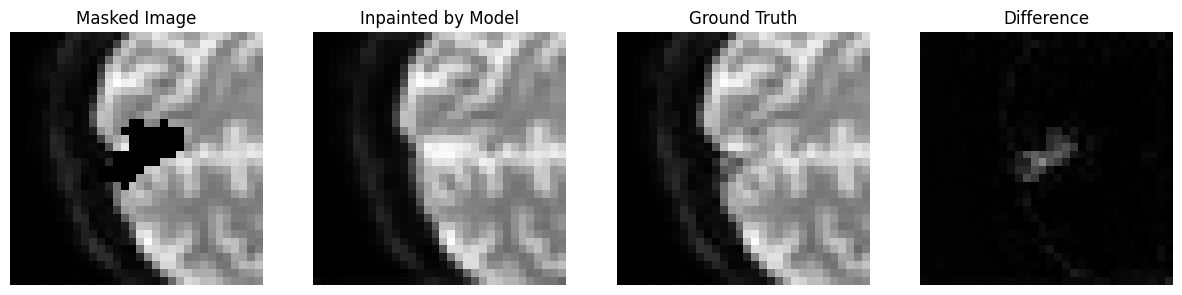

1/1 [==============================] - 0s 23ms/step


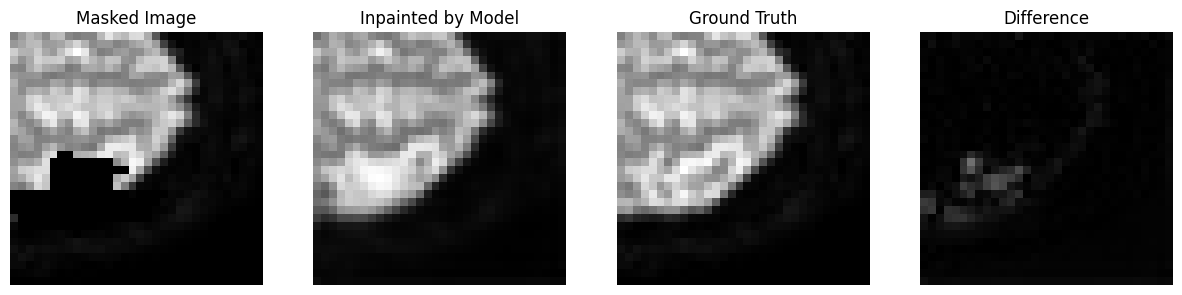

1/1 [==============================] - 0s 23ms/step


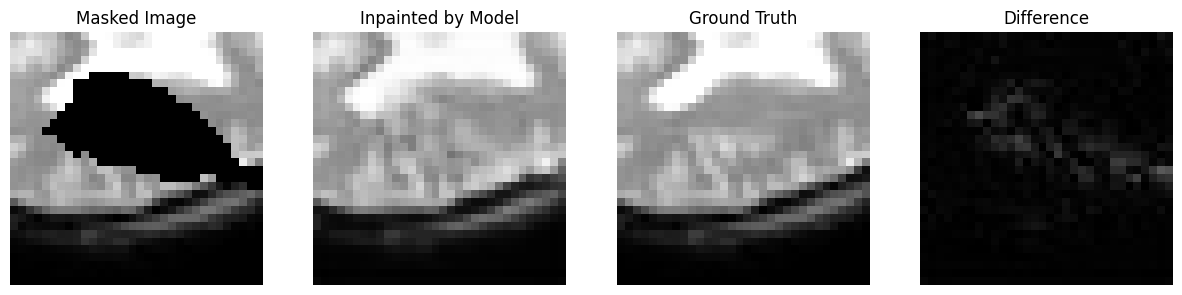

1/1 [==============================] - 0s 22ms/step


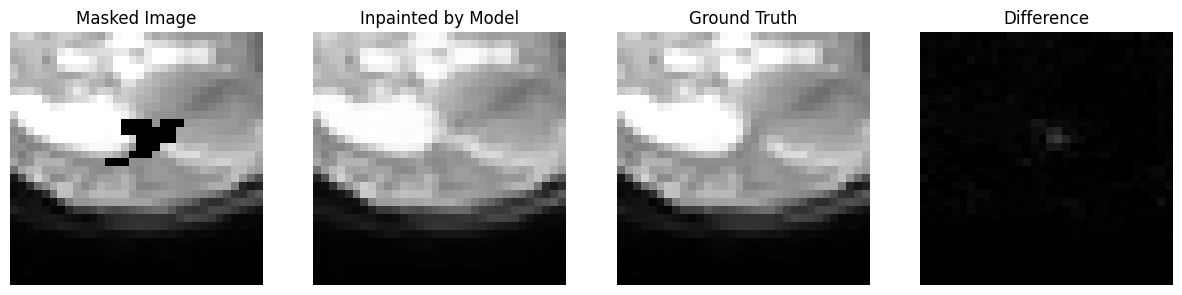

1/1 [==============================] - 0s 22ms/step


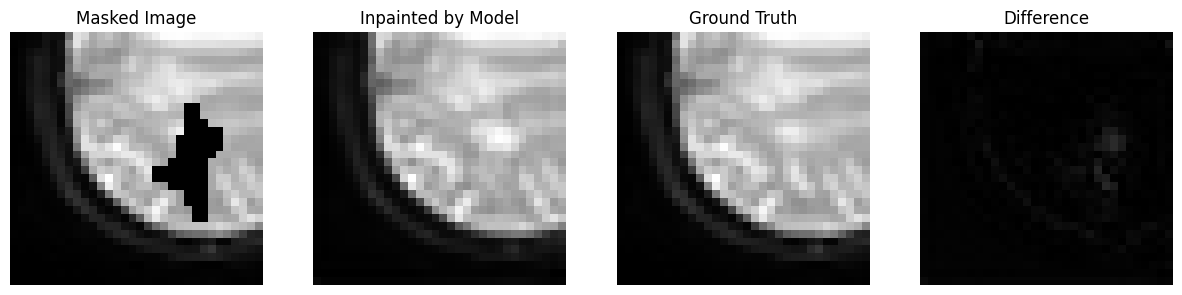

1/1 [==============================] - 0s 23ms/step


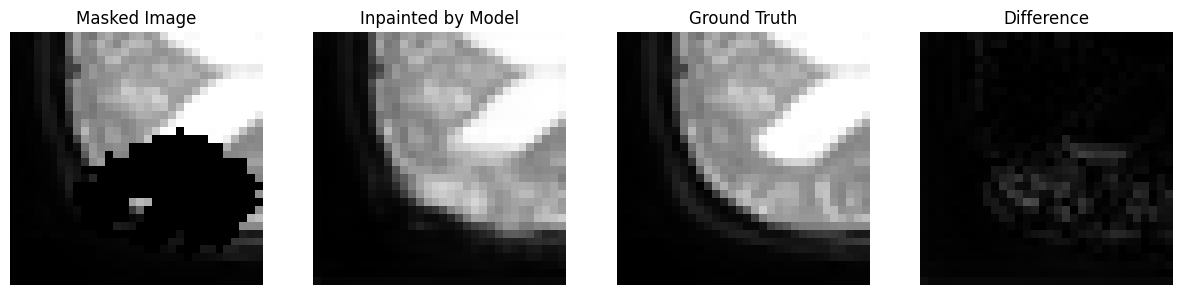

In [ ]:
import matplotlib.pyplot as plt

np.random.seed(11)
num_images_to_show = 10

for i in range(num_images_to_show):
    img_index = np.random.randint(len(X_test))  # Use the length of your dataset

    masked_image = X_test_expand[img_index]
    original_image = y_test[img_index]
    mask = masks_test_expand[img_index]
    prediction = model_pconv_total_loss.predict([masked_image[np.newaxis, ...], mask[np.newaxis, ...]])[0]

    difference = np.abs(prediction.squeeze() - original_image)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(masked_image.squeeze(), cmap='gray')
    plt.title('Masked Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.title('Inpainted by Model')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(difference.squeeze(), cmap='gray',vmin=0,vmax=1)
    plt.title('Difference')
    plt.axis('off')

    plt.show()


# Overall summary

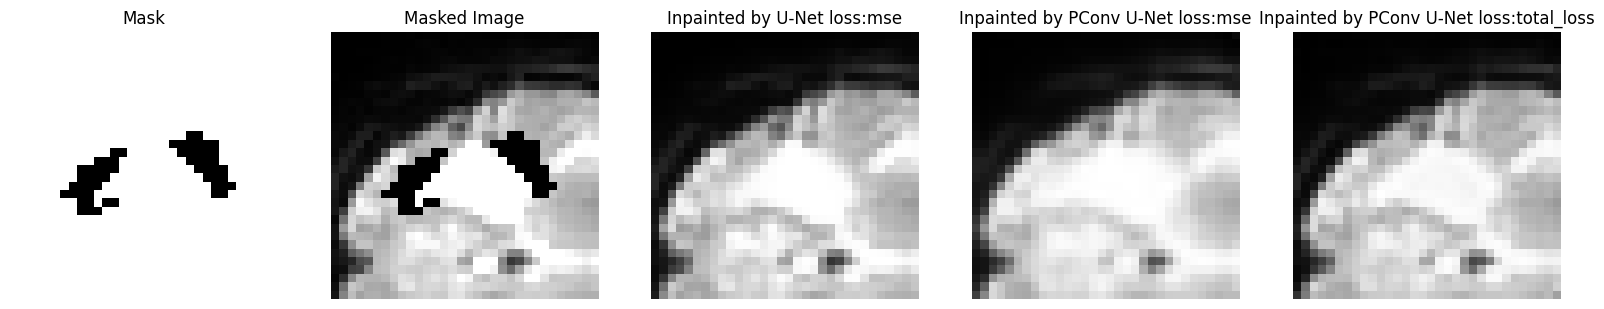

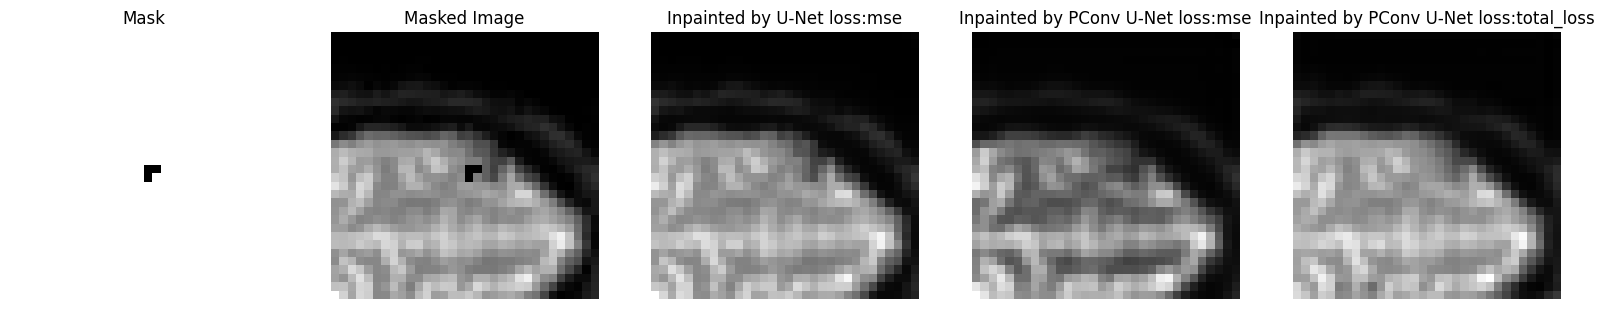

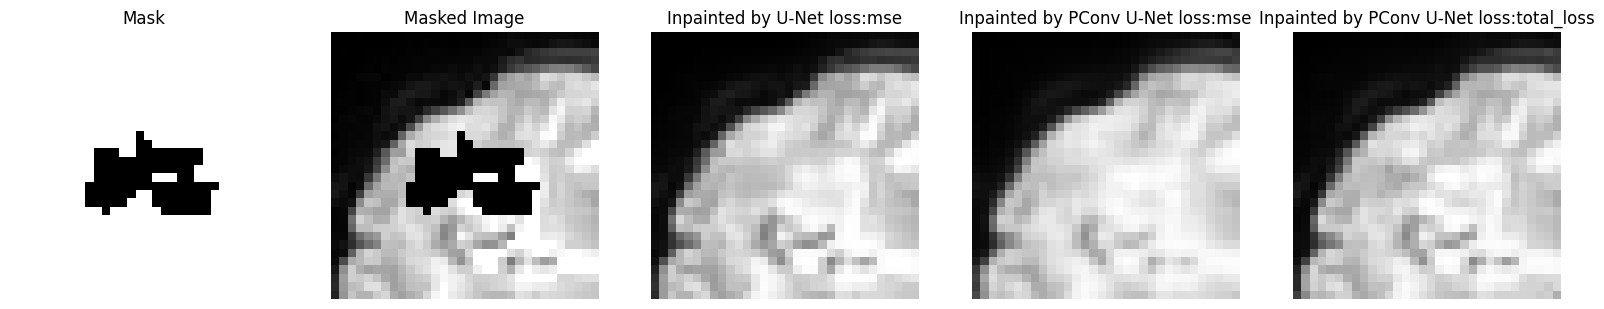

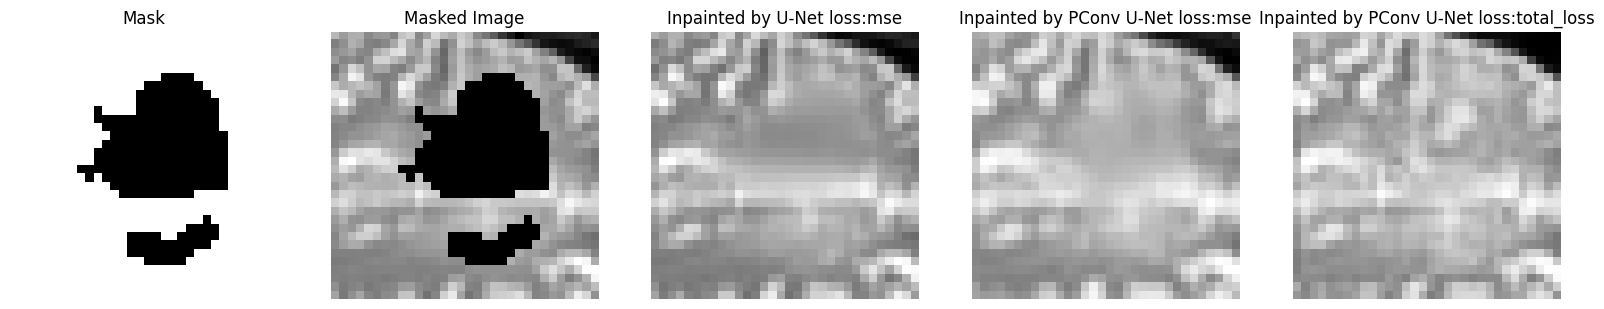

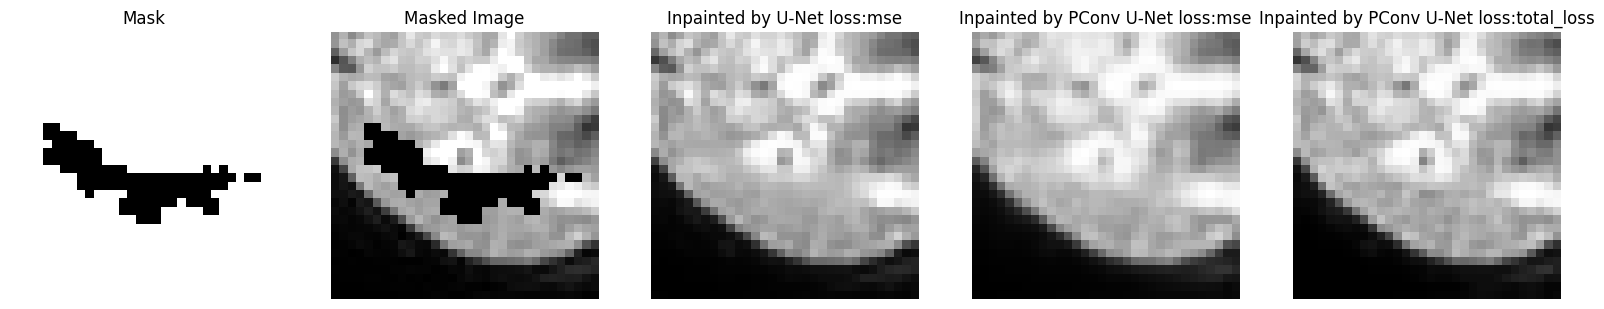

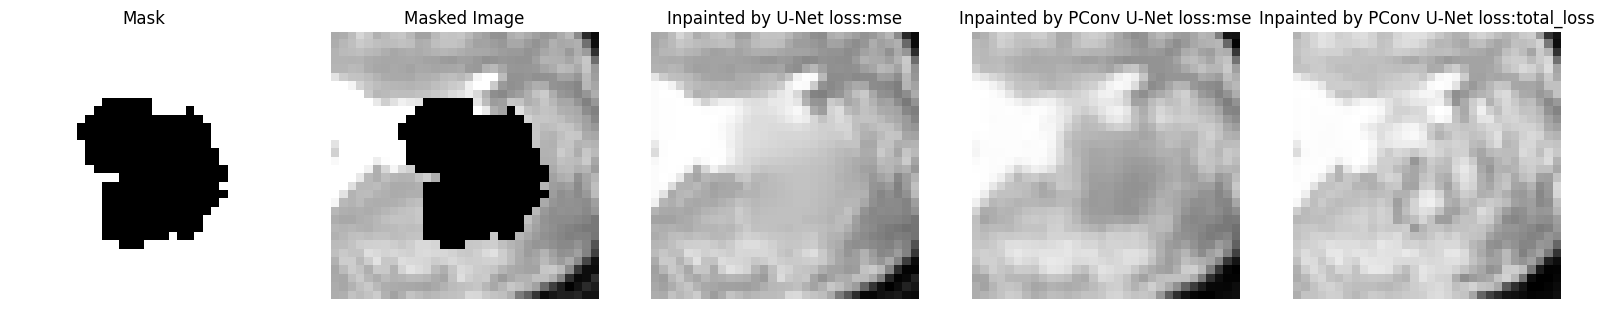

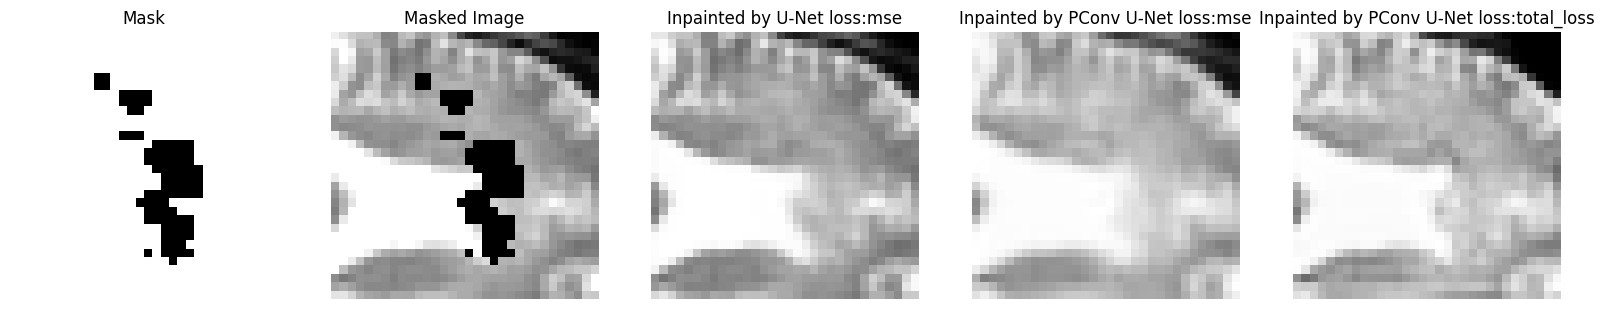

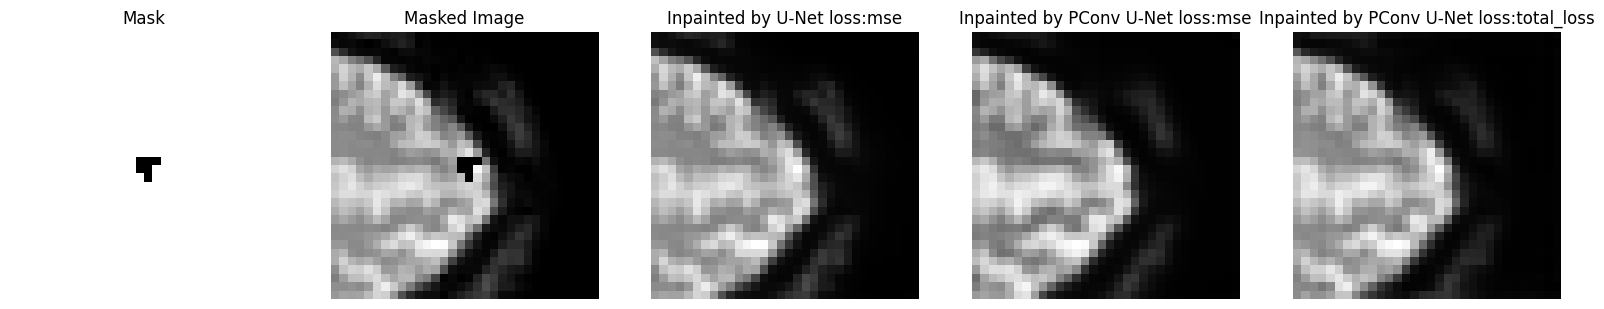

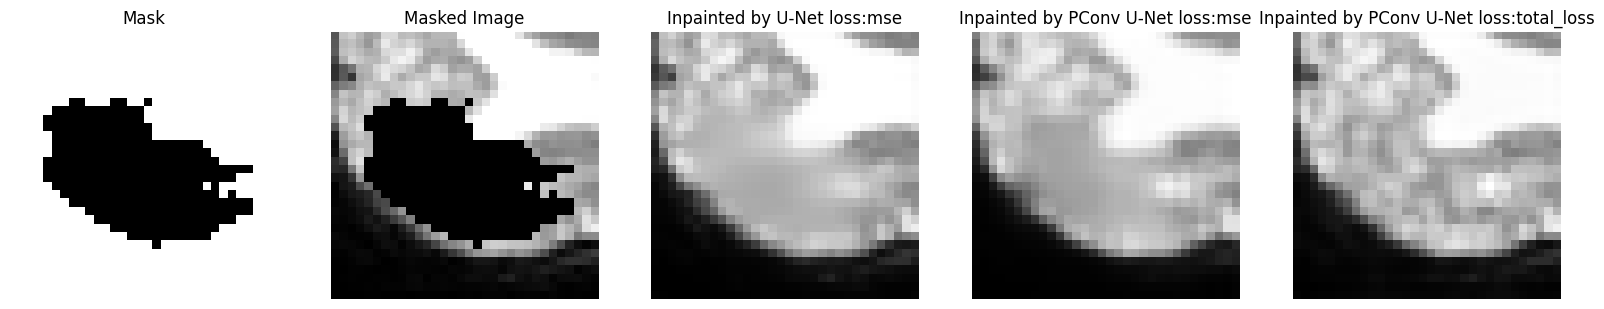

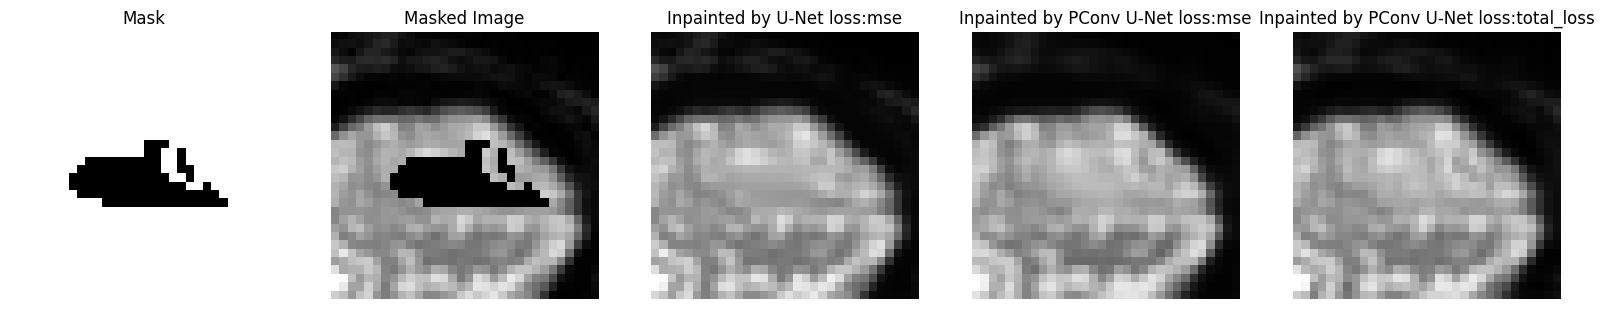

In [ ]:
num_images_to_show = 10

for i in range(num_images_to_show):
    img_index = np.random.randint(len(X_real_test))  # Use the length of your dataset

    masked_image = X_masked_test[img_index]
    original_image = X_real_test[img_index]
    mask = masks_real_test[img_index]

    prediction_1 = model_unet_mse.predict([masked_image[np.newaxis, ...]],verbose=0)[0]
    prediction_2 = model_pconv_unet_mse.predict([masked_image[np.newaxis, ...], mask[np.newaxis, ...]],verbose=0)[0]
    prediction_3 = model_pconv_total_loss.predict([masked_image[np.newaxis, ...], mask[np.newaxis, ...]],verbose=0)[0]


    plt.figure(figsize=(20, 5))

    plt.subplot(1, 5, 1)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(masked_image.squeeze(), cmap='gray')
    plt.title('Masked Image')
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(prediction_1.squeeze(), cmap='gray')
    plt.title('Inpainted by U-Net loss:mse')
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(prediction_2.squeeze(), cmap='gray')
    plt.title('Inpainted by PConv U-Net loss:mse')
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(prediction_3.squeeze(), cmap='gray')
    plt.title('Inpainted by PConv U-Net loss:total_loss')
    plt.axis('off')

    plt.show()
